<font face="Times New Roman" size=6 color=#0099ff> To test the stim coding vailability, we test the v-bias and z bias. </font>

In [2]:
# hddm
import hddm

# generation of design matrices
from patsy import dmatrix

# data analysis and plot
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# parallel computation
from joblib import Parallel, delayed

<font face="Times New Roman" size=6> Simulate Data </font>

<font face="Times New Roman" size=3> we have two experimental factors, one is ``coherence(high and low)`` and the another is ``spatial prioritization(cue and no cue)``. </font>

<font face="Times New Roman" size=3> we assume that ``coherence(high and low)`` affect the parameter ``v`` and ``spatial prioritization(cue and no cue)`` affects ``z``. </font>

<font face="Times New Roman" size=3> we will use ``HDDMRegression`` to simulate the data and then use ``HDDMRegression`` to fit the data. </font>

In [3]:
# subject numbers
n_subjects = 10

# trial numbers
trials_per_level = 150

<font face="Times New Roman" size=3> Because we have two experimental factors, so we have four different levels. They are: </font>

<font face="Times New Roman" size=3> 1. High coherence and cue; </font>

<font face="Times New Roman" size=3> 2. High coherence and no cue; </font>

<font face="Times New Roman" size=3> 3. Low coherence and cue; </font>

<font face="Times New Roman" size=3> 4. Low coherence and no cue; </font>

<font face="Times New Roman" size=3> For the first stimulus, we can set up the parameters of the evidence accumulation process.As described before, ``v`` and ``z`` change across levels; </font>

In [4]:
level1_a = {'v':0.5, 'a':2, 't':0.3, 'z':0.7, 'sv':0, 'sz':0, 'st':0} 

level2_a = {'v':0.5, 'a':2, 't':0.3, 'z':0.5, 'sv':0, 'sz':0, 'st':0} 

level3_a = {'v':0.2, 'a':2, 't':0.3, 'z':0.7, 'sv':0, 'sz':0, 'st':0} 

level4_a = {'v':0.2, 'a':2, 't':0.3, 'z':0.5, 'sv':0, 'sz':0, 'st':0} 

<font face="Times New Roman" size=3> we can simulate the data for stimulus A(Car). </font>

In [5]:
data_a, params_a = hddm.generate.gen_rand_data({
    'level1':level1_a,
    'level2':level2_a,
    'level3':level3_a,
    'level4':level4_a},
    size = trials_per_level,
    subjs = n_subjects
    ) 

<font face="Times New Roman" size=3> For the other stimulus, the parameter ``v`` is the same as the first stimulus. ``z`` is different, ``z(stimulus_b) = 1 - z(stimulus_a)``. </font>

In [6]:
level1_b = {'v':0.5, 'a':2, 't':0.3, 'z':0.3, 'sv':0, 'sz':0, 'st':0} 

level2_b = {'v':0.5, 'a':2, 't':0.3, 'z':0.5, 'sv':0, 'sz':0, 'st':0} 

level3_b = {'v':0.2, 'a':2, 't':0.3, 'z':0.3, 'sv':0, 'sz':0, 'st':0} 

level4_b = {'v':0.2, 'a':2, 't':0.3, 'z':0.5, 'sv':0, 'sz':0, 'st':0} 

<font face="Times New Roman" size=3> we can simulate the data for stimulus B(Face). </font>

In [7]:
data_b, params_b = hddm.generate.gen_rand_data({
    'level1':level1_b,
    'level2':level2_b,
    'level3':level3_b,
    'level4':level4_b},
    size = trials_per_level,
    subjs = n_subjects
    ) 

<font face="Times New Roman" size=3> We could add a column ``DataFrame`` identifying stimulus A(``Car``) as ``0`` and stimulus B(``Face``) as ``1``. </font>

In [8]:
data_a['stimulus'] = pd.Series(np.ones((len(data_a)))*0, index = data_a.index)
data_b['stimulus'] = pd.Series(np.ones((len(data_b))), index = data_b.index)

data_a['coherence'] = pd.Series(np.hstack((np.ones(int(len(data_a)/2))*1,np.ones(int(len(data_a)/2))*0)), index = data_a.index)
data_b['coherence'] = pd.Series(np.hstack((np.ones(int(len(data_a)/2))*1,np.ones(int(len(data_a)/2))*0)), index = data_b.index)

data_a['attention'] = pd.Series(np.hstack((np.ones(int(len(data_a)/4))*1,np.ones(int(len(data_a)/4))*0,np.ones(int(len(data_a)/4))*1,np.ones(int(len(data_a)/4))*0)), index = data_a.index)
data_b['attention'] = pd.Series(np.hstack((np.ones(int(len(data_a)/4))*1,np.ones(int(len(data_a)/4))*0,np.ones(int(len(data_a)/4))*1,np.ones(int(len(data_a)/4))*0)), index = data_b.index)

# merge data for stimulus A(Car) and B(Face)
data = data_a.append(data_b, ignore_index = True)

/tmp/ipykernel_10127/3847642742.py:11: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data = data_a.append(data_b, ignore_index = True)


<font face="Times New Roman" size=3> We then check the ``data``. </font>

In [9]:
rawdata = data

<font face="Times New Roman" size=6> Fit Data </font>

<font face="Times New Roman" size=3> We would like to test the stimcoding and fit the fake data to the model and to compare the ``estimated parameter`` and the ``true parameter``. </font>

<font face="Times New Roman" size=3> We use ``z_link_func`` to ensure that the bias for one stimulus is ``z`` and the other is ``1-z``. </font>

In [10]:
def z_link_func(x, data=data):
        stim = (np.asarray(dmatrix('0 + C(s, [[0], [1]])',
                                  {'s': data.stimulus.loc[x.index]},return_type='dataframe'))
        )
        # Apply z = (1 - x) to flip them along 0.5
        z_flip = np.subtract(stim, x.to_frame())
        # The above inverts those values we do not want to flip,
        # so invert them back
        z_flip[stim == 0] *= -1
        return z_flip

<font face="Times New Roman" size=3> Then we set up the regression model for ``z`` and ``v`` and also include the link function. </font>

<font face="Times New Roman" size=5> 1.with z link func </font>

In [11]:
# The link function for ``z`` is:
z_reg = {'model': "z ~ 1 + C(attention,Treatment(0))", 'link_func':z_link_func}
# The link function for ``v`` is:
v_reg = {'model': "v ~ 1 + C(coherence,Treatment(0))", 'link_func': lambda x:x}
# Then we can put the regression description for the hddm model.
reg_descr = [z_reg, v_reg]
# Finally we run the regression model 
m_reg = hddm.HDDMRegressor(data, 
                            reg_descr,
                            include=['z'],       
                            group_only_regressors=True,
                            p_outlier=.05)
m_reg.find_starting_values()
m_reg.sample(8000,burn=1000)

<font face="Times New Roman" size=3> Check the true parameter and estimated parameter. </font>

<font face="Times New Roman" size=3> Remember that our goal is to confirm the coding is true. </font>

Plotting a
Plotting a_std
Plotting t
Plotting t_std
Plotting z_Intercept
Plotting z_Intercept_std
Plotting z_C(attention, Treatment(0))[T.1.0]
Plotting v_Intercept
Plotting v_Intercept_std
Plotting v_C(coherence, Treatment(0))[T.1.0]


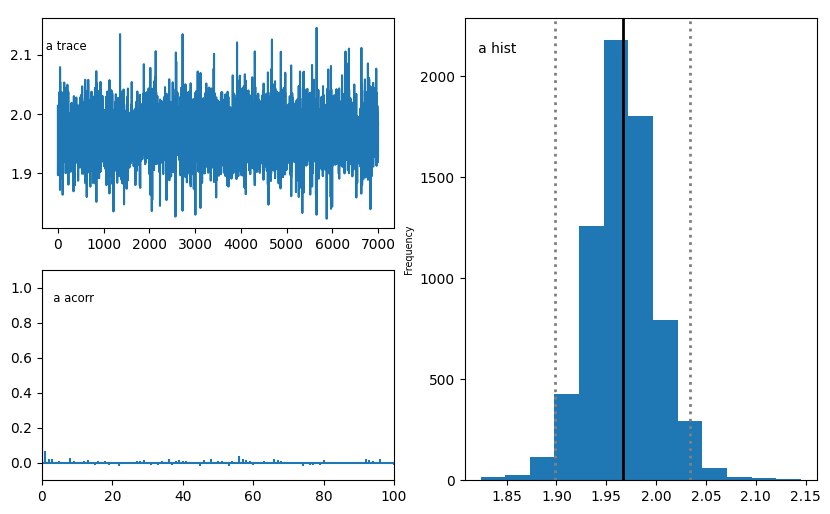

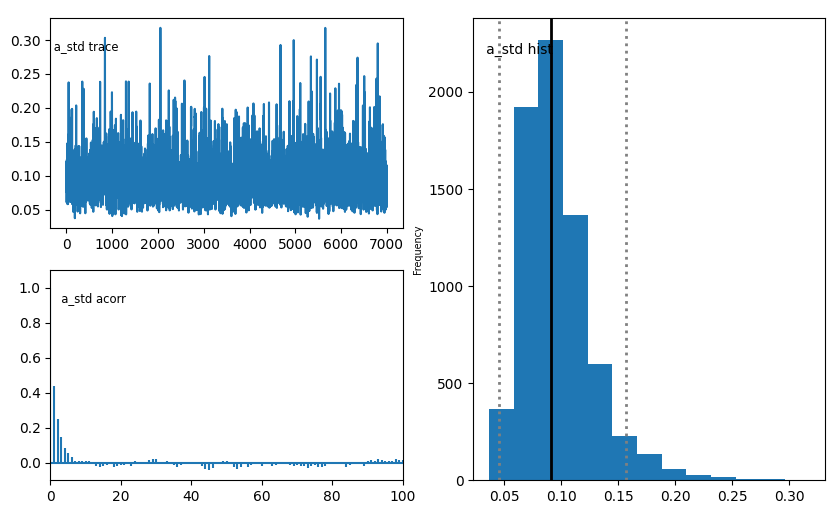

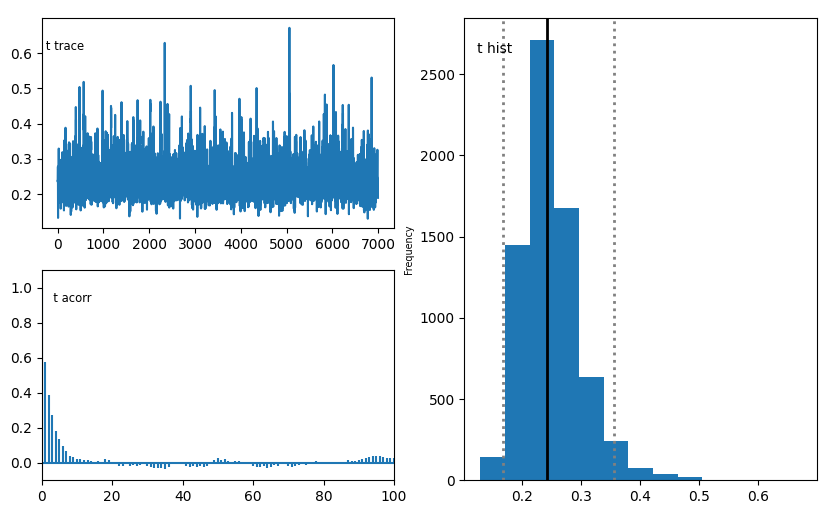

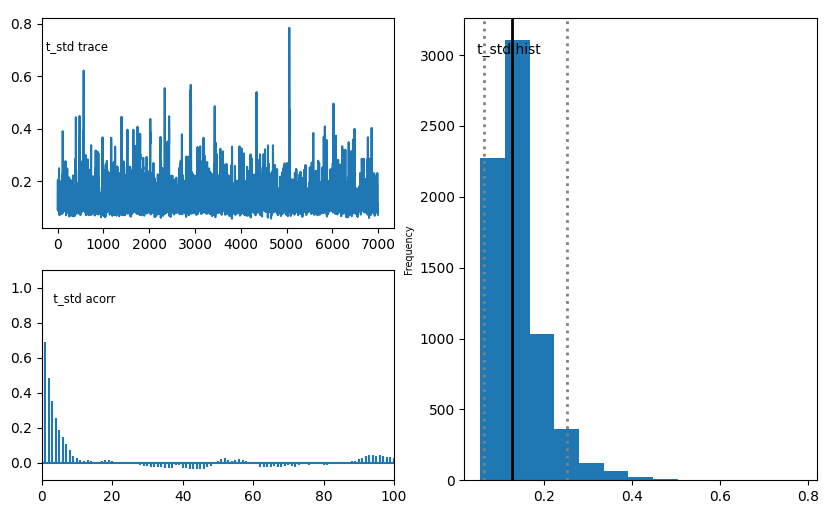

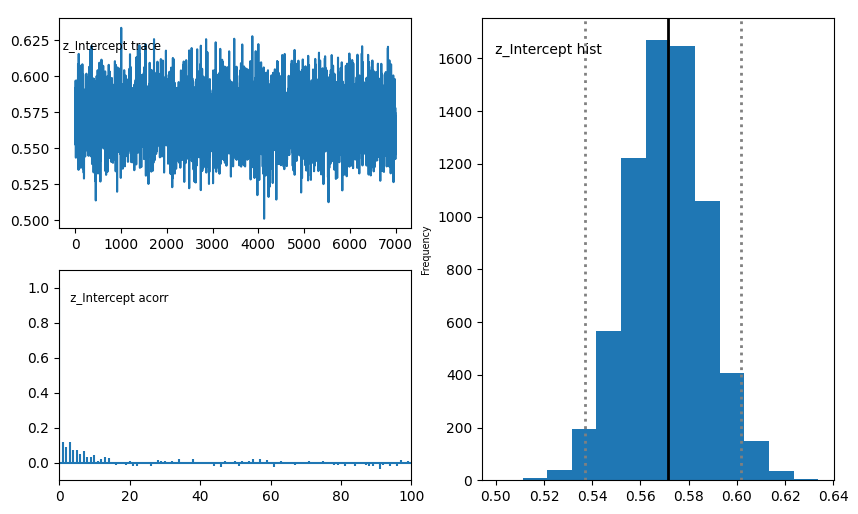

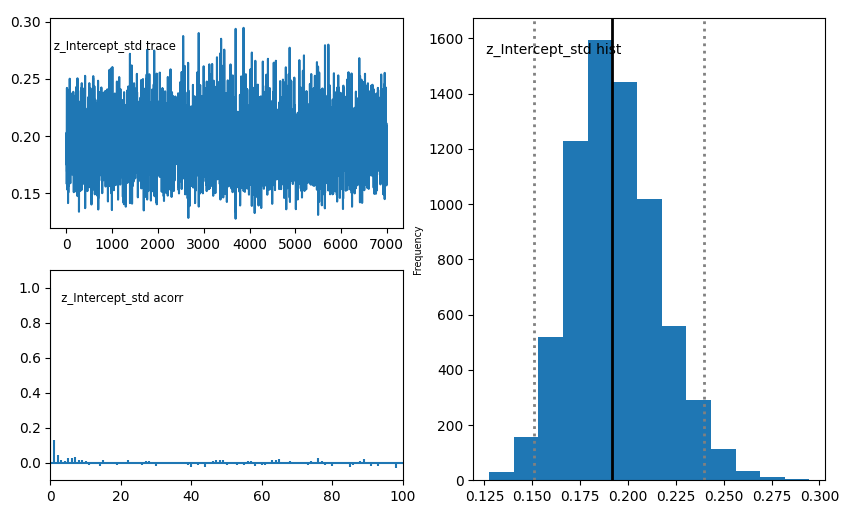

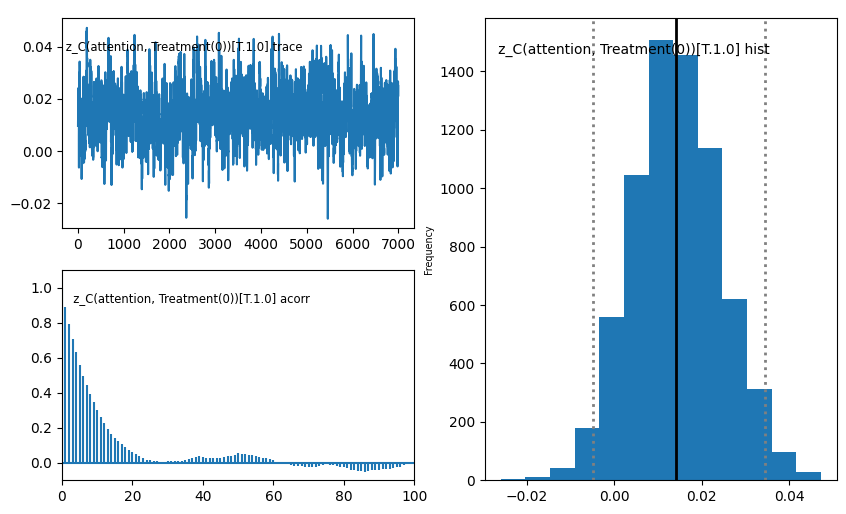

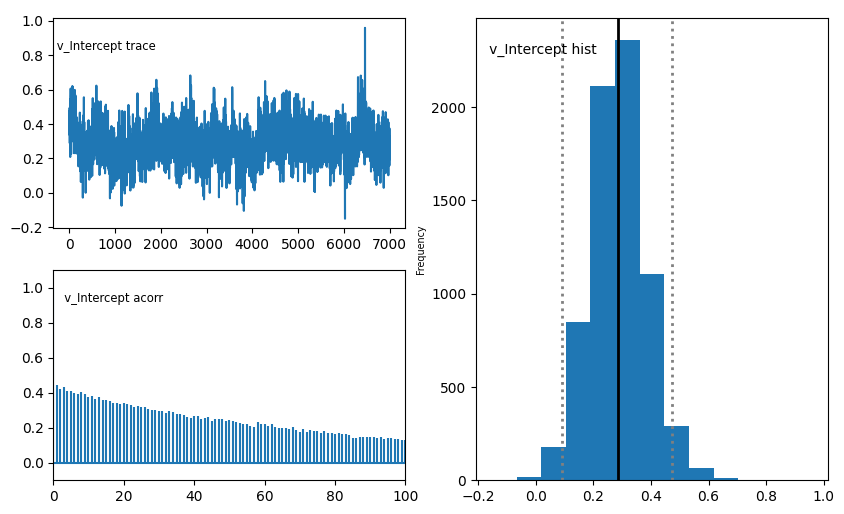

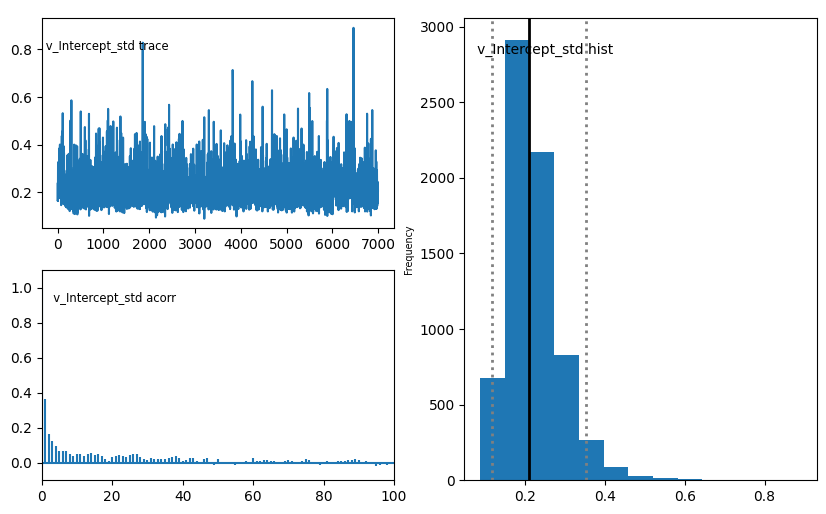

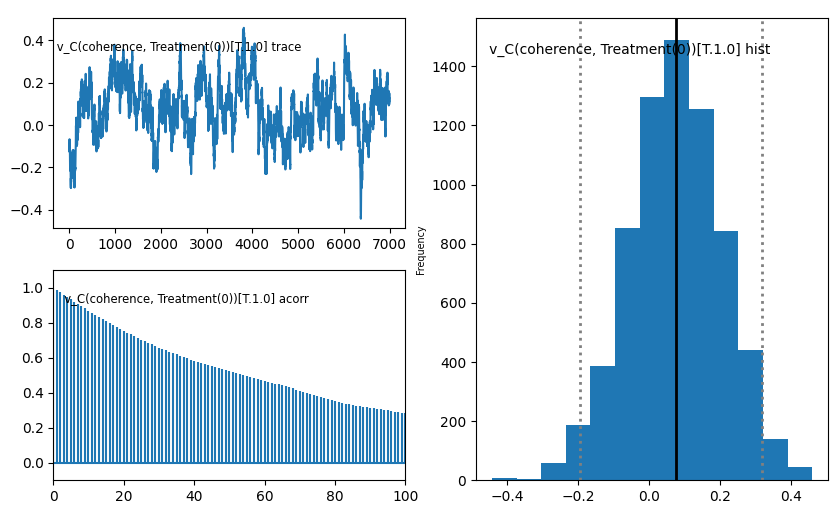

In [85]:
m_reg.plot_posteriors()

<font face="Times New Roman" size=3> Print the stats. </font>

In [77]:
m_reg.print_stats()

                                         mean       std      2.5q       25q       50q       75q     97.5q    mc err
a                                    1.968606  0.031594  1.905558  1.948587  1.968247  1.988471  2.033773  0.001293
a_std                                0.095484  0.029143  0.054537  0.076023   0.09092  0.107539  0.165511   0.00137
a_subj.0                             1.850131  0.026165  1.800903  1.831285  1.849168   1.86985  1.901123   0.00103
a_subj.1                             2.044155  0.030737  1.984652  2.022284  2.044869  2.065864  2.107165  0.001322
a_subj.2                             2.089944  0.032626  2.030175  2.068324  2.089492  2.110959  2.157605  0.001267
a_subj.3                             1.891745  0.027562  1.838823  1.872843  1.892508  1.910614  1.945967  0.001247
a_subj.4                             1.932148  0.026652    1.8776   1.91446  1.931472  1.949634   1.98665  0.001181
a_subj.5                             1.975498  0.028102  1.920705   1.95

<font face="Times New Roman" size=5> 2.with z link func with more runs. </font>

In [86]:
# The link function for ``z`` is:
z_reg = {'model': "z ~ 1 + C(attention,Treatment(0))", 'link_func':z_link_func}
# The link function for ``v`` is:
v_reg = {'model': "v ~ 1 + C(coherence,Treatment(0))", 'link_func': lambda x:x}
# Then we can put the regression description for the hddm model.
reg_descr = [z_reg, v_reg]
# Finally we run the regression model 
m_reg1 = hddm.HDDMRegressor(data, 
                            reg_descr,
                            include=['z'],       
                            group_only_regressors=True,
                            p_outlier=.05)
m_reg1.find_starting_values()
m_reg1.sample(20000,burn=5000)

Adding these covariates:
['z_Intercept', 'z_C(attention, Treatment(0))[T.1.0]']
Adding these covariates:
['v_Intercept', 'v_C(coherence, Treatment(0))[T.1.0]']


/home/yikang1020/anaconda3/envs/hddm38/lib/python3.8/site-packages/scipy/optimize/optimize.py:2116: RuntimeWarning: invalid value encountered in double_scalars
  tmp2 = (x - v) * (fx - fw)
/home/yikang1020/anaconda3/envs/hddm38/lib/python3.8/site-packages/scipy/optimize/optimize.py:2116: RuntimeWarning: invalid value encountered in double_scalars
  tmp2 = (x - v) * (fx - fw)
/home/yikang1020/anaconda3/envs/hddm38/lib/python3.8/site-packages/scipy/optimize/optimize.py:2116: RuntimeWarning: invalid value encountered in double_scalars
  tmp2 = (x - v) * (fx - fw)
/home/yikang1020/anaconda3/envs/hddm38/lib/python3.8/site-packages/scipy/optimize/optimize.py:2116: RuntimeWarning: invalid value encountered in double_scalars
  tmp2 = (x - v) * (fx - fw)
/home/yikang1020/anaconda3/envs/hddm38/lib/python3.8/site-packages/scipy/optimize/optimize.py:2116: RuntimeWarning: invalid value encountered in double_scalars
  tmp2 = (x - v) * (fx - fw)
/home/yikang1020/anaconda3/envs/hddm38/lib/python3.8/si

 [-----------------100%-----------------] 20001 of 20000 complete in 27921.5 sec

Plotting a
Plotting a_std
Plotting t
Plotting t_std
Plotting z_Intercept
Plotting z_Intercept_std
Plotting z_C(attention, Treatment(0))[T.1.0]
Plotting v_Intercept
Plotting v_Intercept_std
Plotting v_C(coherence, Treatment(0))[T.1.0]


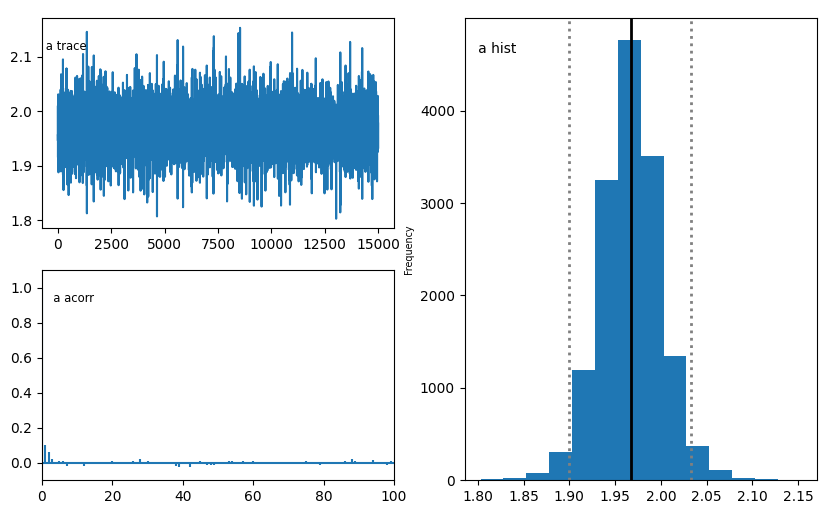

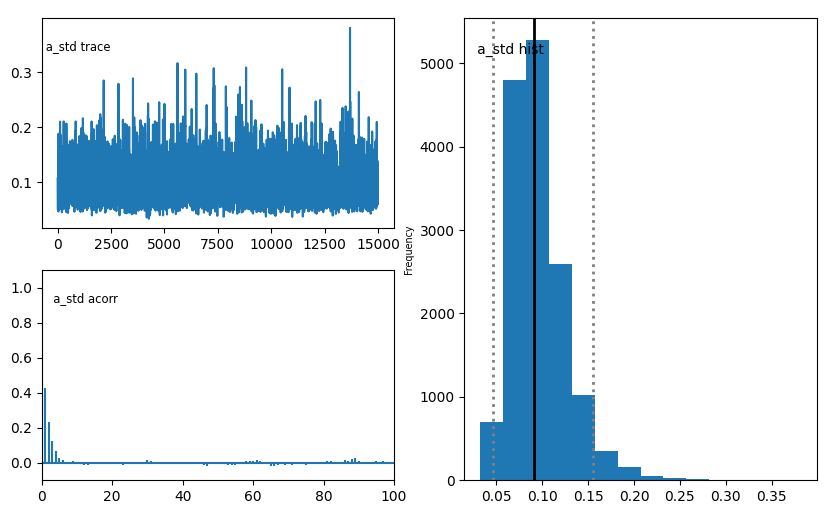

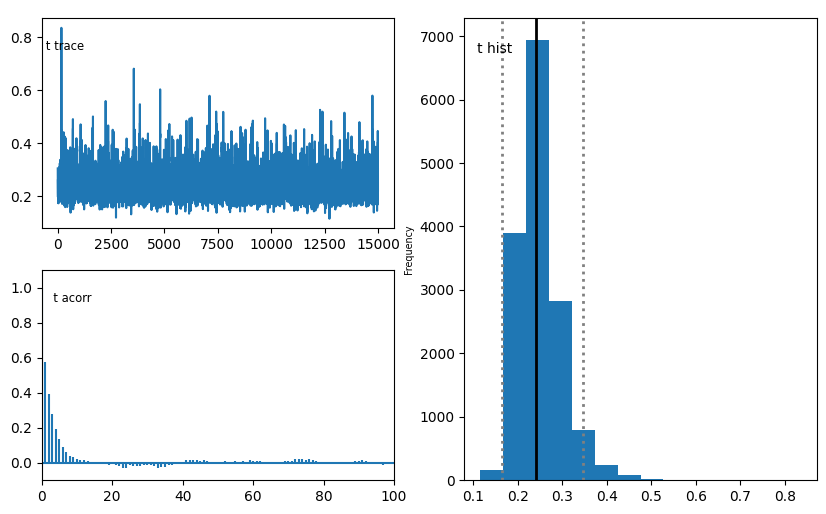

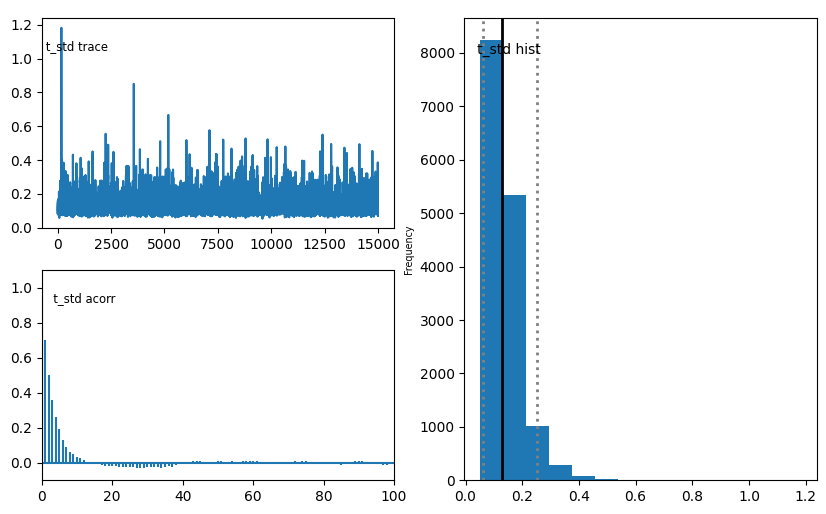

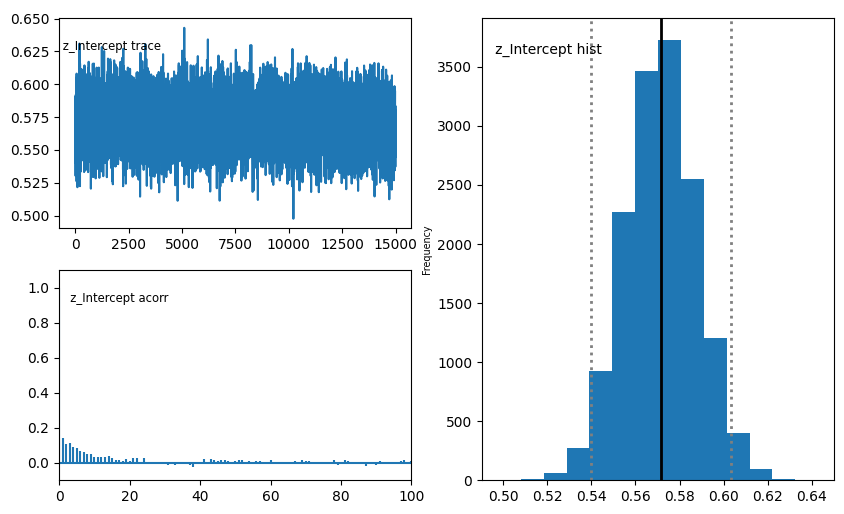

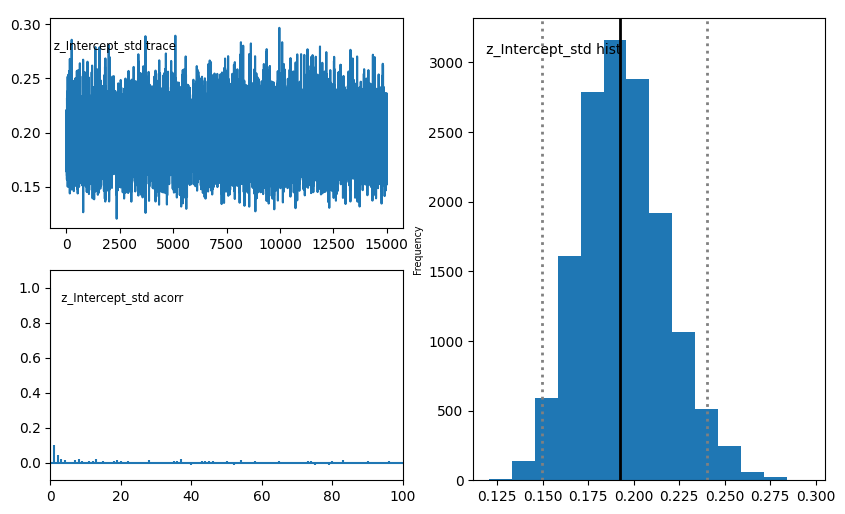

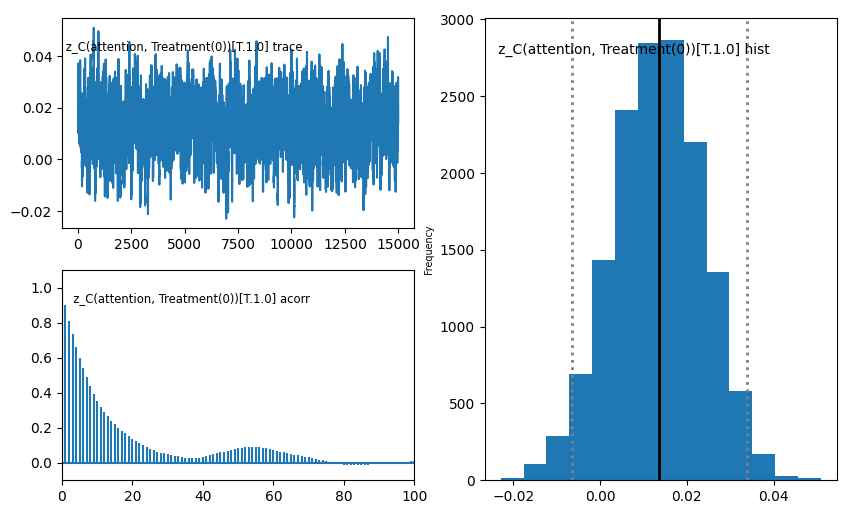

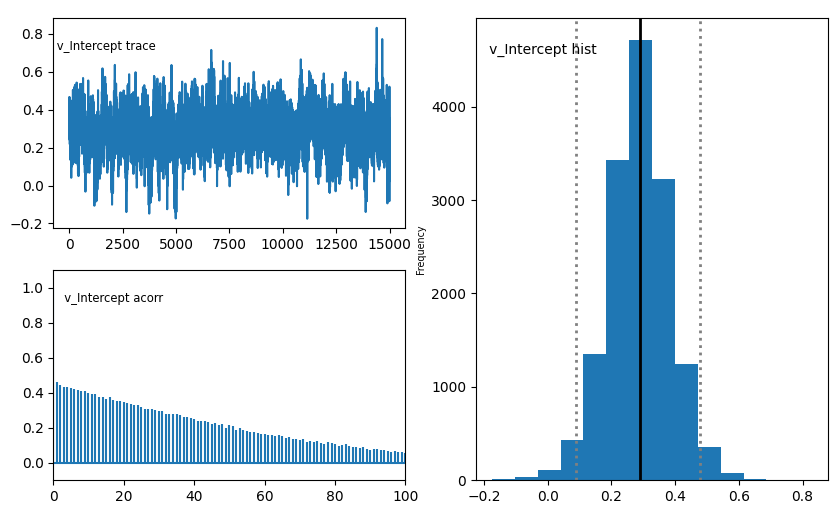

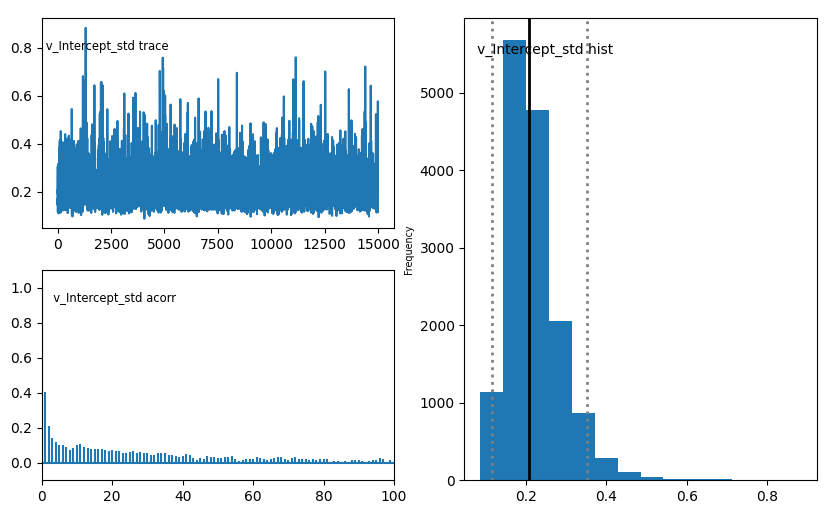

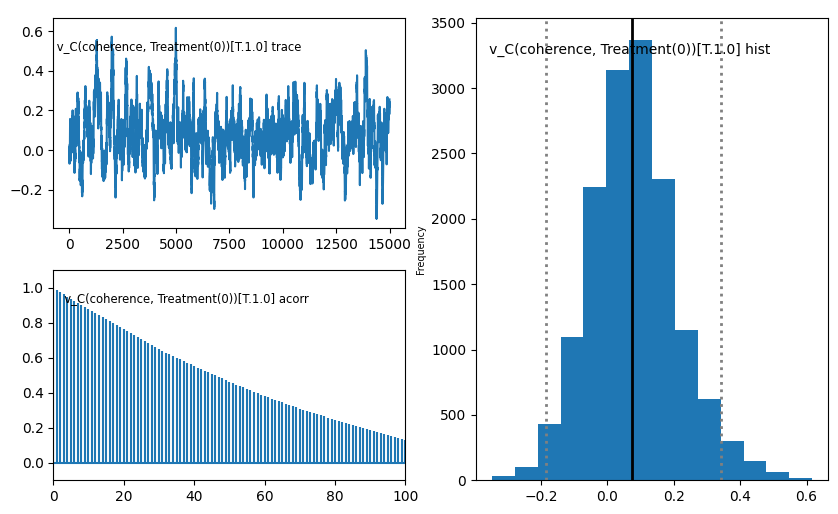

In [87]:
m_reg1.plot_posteriors()

In [89]:
m_reg1.gen_stats()

                                         mean       std      2.5q       25q       50q       75q     97.5q    mc err
a                                    1.967179  0.033683  1.901106  1.946438  1.966963  1.987577  2.034862  0.000307
a_std                                0.096373  0.030458  0.053504  0.075541  0.090906   0.11079  0.173266   0.00042
a_subj.0                             1.850999  0.026325  1.799509  1.833237  1.850986  1.868576  1.902772  0.000326
a_subj.1                             2.042162  0.030895  1.982461  2.021557  2.041233  2.062577    2.1036  0.000356
a_subj.2                             2.088769  0.032404  2.026306   2.06691  2.088251    2.1102  2.154154   0.00038
a_subj.3                             1.890976  0.026861  1.838819  1.872967  1.890925  1.908795  1.944238  0.000281
a_subj.4                             1.931099  0.028037  1.876872  1.912158  1.931003  1.949907  1.986113  0.000321
a_subj.5                             1.978208  0.028621  1.923377  1.958

<font face="Times New Roman" size=5> 3.without z link func with more runs. </font>

In [16]:
# The link function for ``z`` is:
z_reg = {'model': "z ~ 1 + C(attention,Treatment(0))", 'link_func': lambda x:x}
# The link function for ``v`` is:
v_reg = {'model': "v ~ 1 + C(coherence,Treatment(0))", 'link_func': lambda x:x}
# Then we can put the regression description for the hddm model.
reg_descr = [z_reg, v_reg]
# Finally we run the regression model 
m_reg2 = hddm.HDDMRegressor(data, 
                            reg_descr,
                            include=['z'],       
                            p_outlier=.05)
m_reg2.find_starting_values()
m_reg2.sample(2000,burn=1000)

Adding these covariates:
['z_Intercept', 'z_C(attention, Treatment(0))[T.1.0]']
Adding these covariates:
['v_Intercept', 'v_C(coherence, Treatment(0))[T.1.0]']


/home/yikang1020/anaconda3/envs/hddm38/lib/python3.8/site-packages/scipy/optimize/optimize.py:2116: RuntimeWarning: invalid value encountered in double_scalars
  tmp2 = (x - v) * (fx - fw)


 [-----------------100%-----------------] 2001 of 2000 complete in 531.6 sec

Plotting a
Plotting a_std
Plotting t
Plotting t_std
Plotting z_Intercept
Plotting z_Intercept_std
Plotting z_C(attention, Treatment(0))[T.1.0]
Plotting v_Intercept
Plotting v_Intercept_std
Plotting v_C(coherence, Treatment(0))[T.1.0]


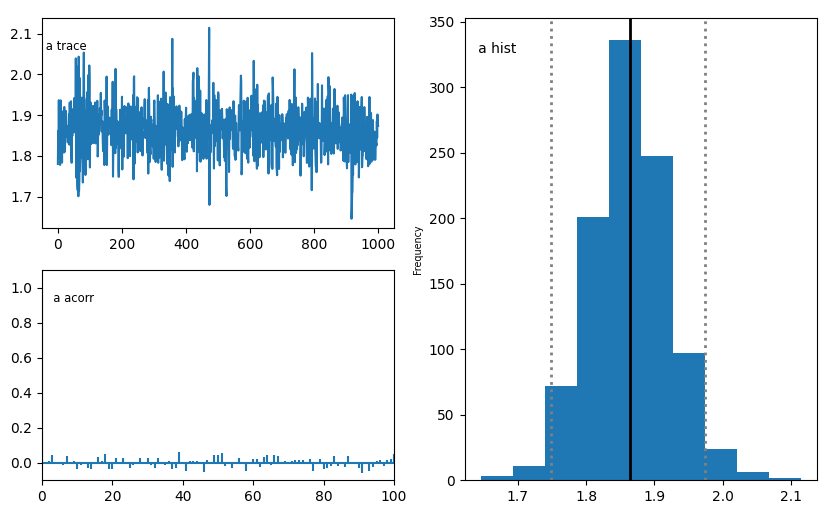

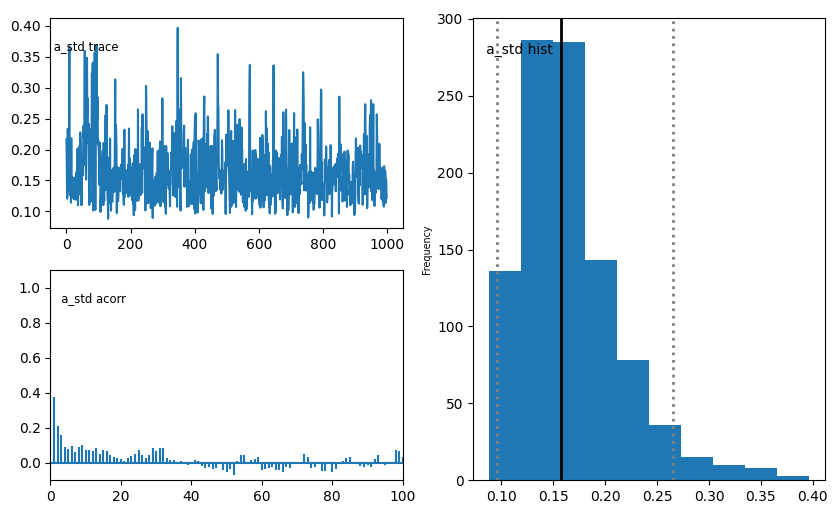

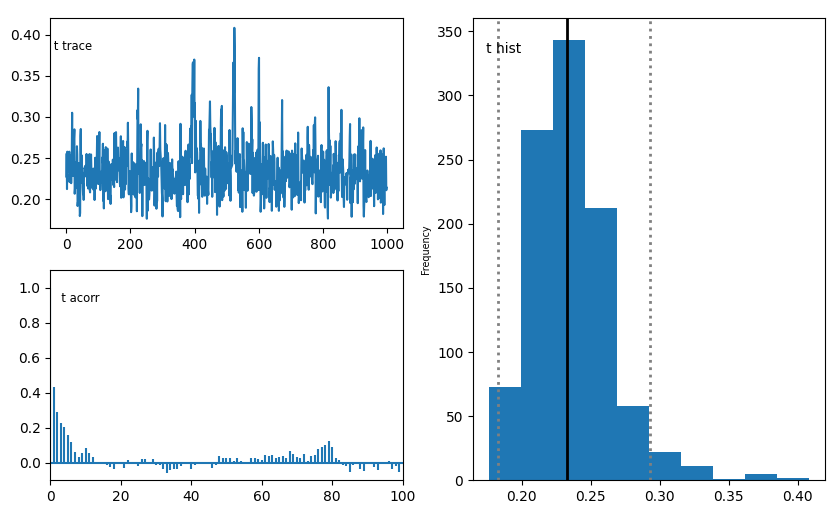

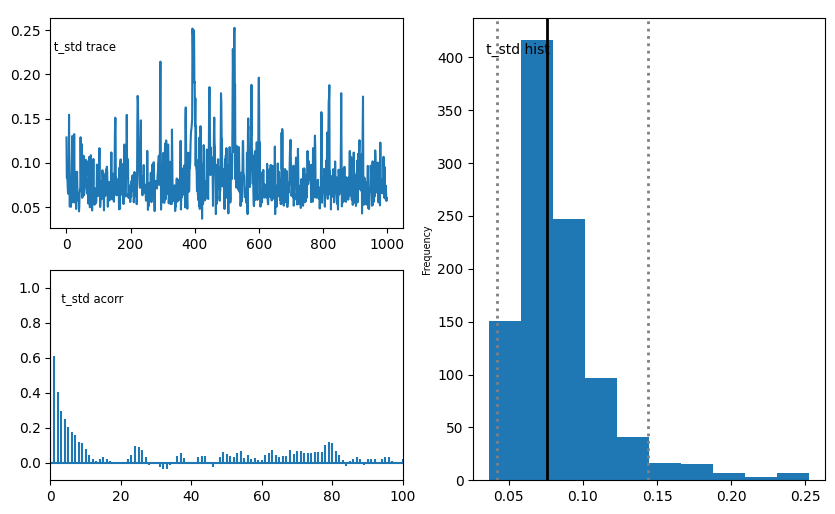

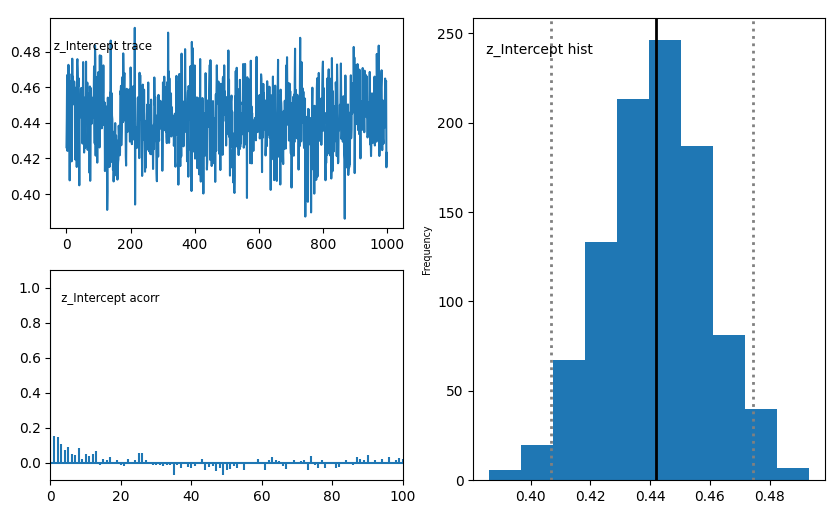

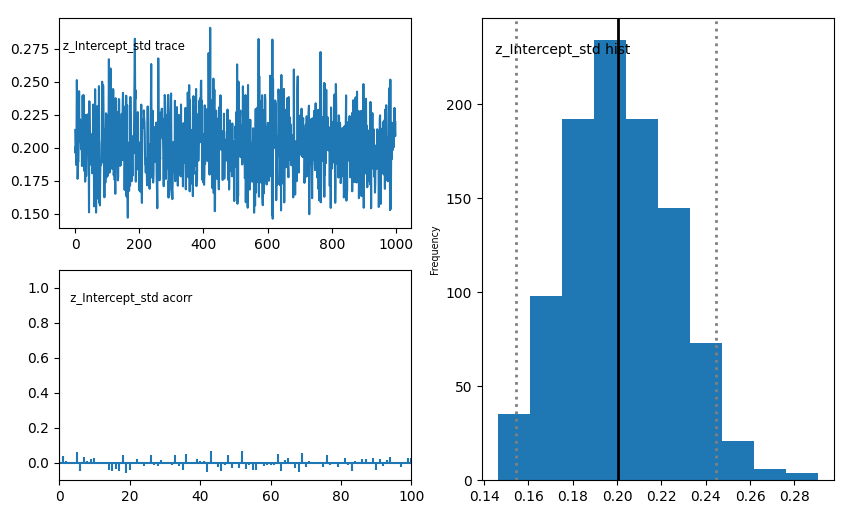

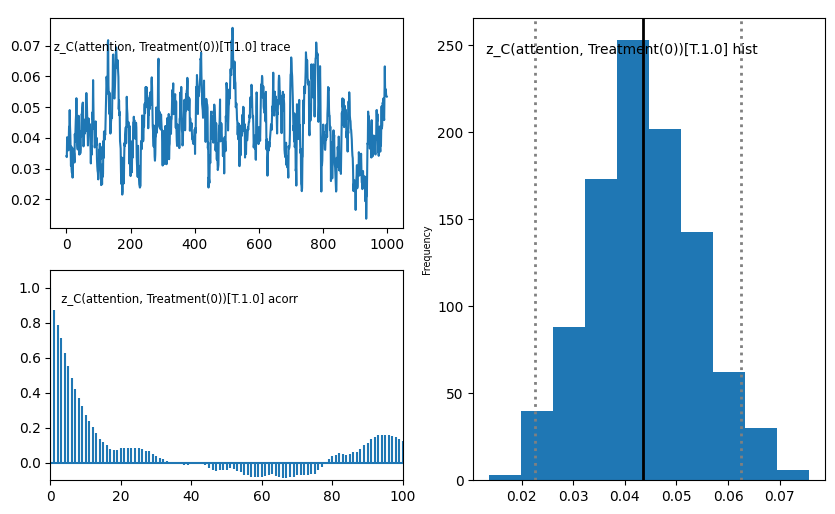

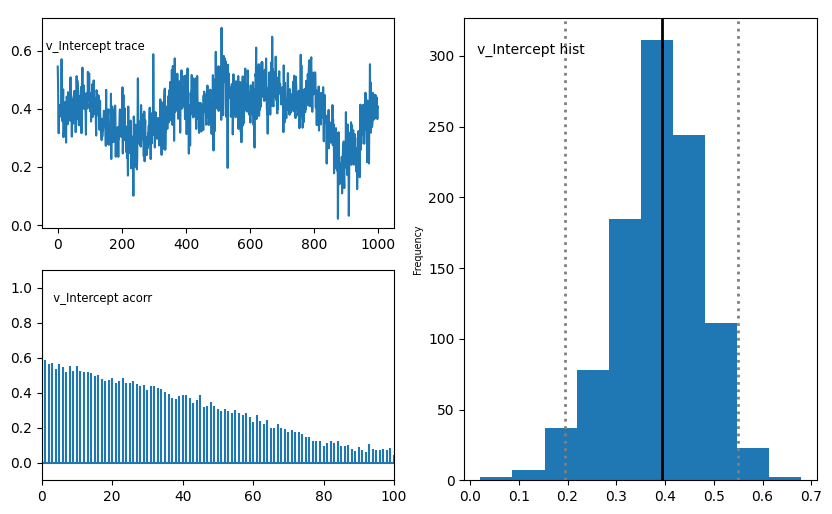

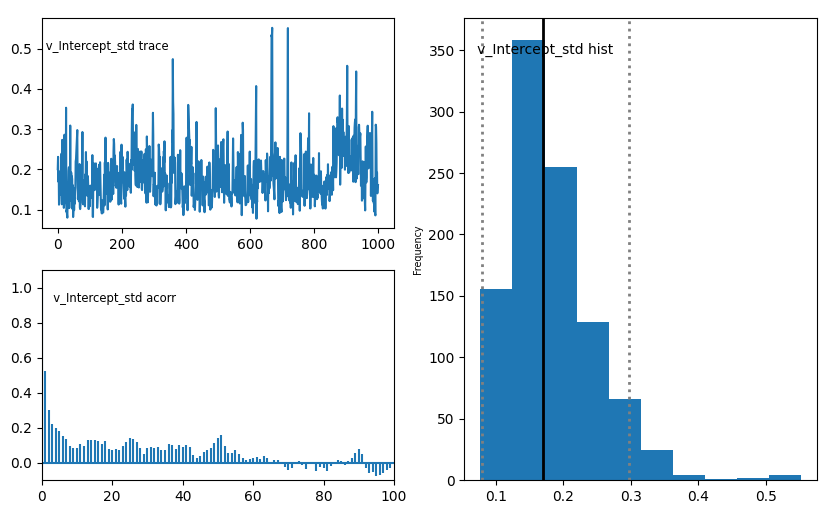

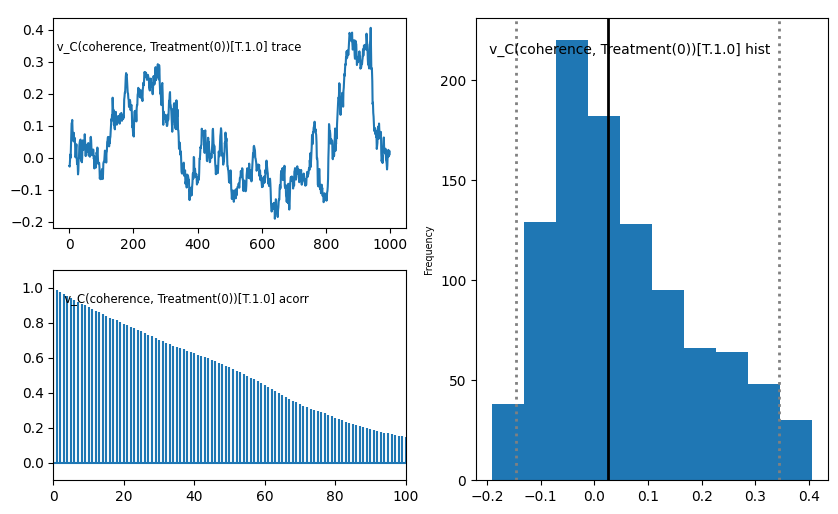

In [19]:
m_reg2.plot_posteriors()

In [18]:
m_reg2.gen_stats()

mean       std      2.5q       25q  \
a                                    1.864432  0.057996  1.754469  1.827424   
a_std                                0.166673  0.048451  0.101069  0.133809   
a_subj.0                             1.830863  0.026331  1.777331  1.812536   
a_subj.1                             1.796039  0.026982  1.743512  1.777777   
a_subj.2                             1.894212  0.028881  1.837869  1.874405   
a_subj.3                             2.053335  0.029245  1.992281  2.034198   
a_subj.4                             1.732303  0.025671   1.68384  1.715921   
a_subj.5                             1.854171  0.027734  1.800627  1.836062   
a_subj.6                             1.987143  0.031707  1.924331  1.966199   
a_subj.7                             1.929416   0.02983  1.875323  1.909698   
a_subj.8                             2.004576  0.030031  1.947489  1.984575   
a_subj.9                             1.598737  0.025641   1.55179   1.58134   
t                                    0.235968   0.02968  0.188758  0.216795   
t_std                                0.083709  0.031073  0.049022  0.063883   
t_subj.0                             0.233361  0.007755   0.21772  0.227801   
t_subj.1                             0.168376  0.006071  0.156428  0.164259   
t_subj.2                             0.258959  0.007713  0.243919  0.253393   
t_subj.3                             0.278713  0.008874   0.26131  0.272666   
t_subj.4                             0.191182  0.006088  0.178408  0.187156   
t_subj.5                              0.27418  0.008321  0.257642  0.268709   
t_subj.6                             0.182737  0.009006  0.165005  0.176399   
t_subj.7                             0.232022  0.008154  0.215489   0.22681   
t_subj.8                             0.108589  0.008083  0.093089  0.103192   
t_subj.9                             0.310577  0.005759  0.298985  0.306842   
z_Intercept                          0.441926  0.017348  0.407455  0.430512   
z_Intercept_std                      0.201785  0.023918  0.158304  0.185066   
z_Intercept_subj.0                   0.365006  0.013478  0.337376  0.355857   
z_Intercept_subj.1                   0.333705  0.013915  0.305973  0.324747   
z_Intercept_subj.2                   0.515559  0.013284   0.49018  0.506731   
z_Intercept_subj.3                   0.461259  0.010582  0.439232  0.454618   
z_Intercept_subj.4                   0.383234  0.009501  0.364772  0.376474   
z_Intercept_subj.5                   0.460081  0.014323  0.432097  0.450553   
z_Intercept_subj.6                   0.420681  0.014337  0.391865  0.411769   
z_Intercept_subj.7                   0.456222  0.011431  0.434361  0.448184   
z_Intercept_subj.8                   0.422868  0.010409  0.401809  0.416488   
z_Intercept_subj.9                   0.607684  0.010936  0.585647   0.60071   
z_C(attention, Treatment(0))[T.1.0]  0.043859  0.010245  0.024469  0.037091   
v_Intercept                           0.38682  0.089722  0.194904  0.331137   
v_Intercept_std                      0.183275  0.063466  0.098153  0.138841   
v_Intercept_subj.0                   0.305879  0.137988  0.003591  0.219235   
v_Intercept_subj.1                   0.430181  0.138035   0.12922  0.347423   
v_Intercept_subj.2                   0.435422  0.139057  0.124426  0.347806   
v_Intercept_subj.3                   0.332593  0.137018  0.024983  0.252084   
v_Intercept_subj.4                   0.288178  0.135146 -0.004387  0.198063   
v_Intercept_subj.5                   0.384638  0.041101  0.305308  0.357122   
v_Intercept_subj.6                   0.449855  0.038158  0.377418  0.424071   
v_Intercept_subj.7                   0.477315  0.038502  0.398539  0.451813   
v_Intercept_subj.8                   0.626057  0.040393  0.547699   0.59787   
v_Intercept_subj.9                   0.115415  0.048516  0.021423  0.079191   
v_C(coherence, Treatment(0))[T.1.0]  0.053602  0.134324 -0.139408 -0.052277   

           

<font face="Times New Roman" size=5> 4.without z link func with more runs. </font>

<font face="Times New Roman" size=3> stimulus coding for ``response`` </font>

In [42]:

data.loc[(data['stimulus']==0)&(data['response']==0),'_response'] = 0
data.loc[(data['stimulus']==0)&(data['response']==1),'_response'] = 1
data.loc[(data['stimulus']==1)&(data['response']==0),'_response'] = 0
data.loc[(data['stimulus']==1)&(data['response']==1),'_response'] = 1
data['response'] = data['_response']

In [26]:
z_reg = {'model': "z ~ 1 + C(attention,Treatment(0))", 'link_func': lambda x:x}
v_reg = {'model': "v ~ 1 + C(coherence,Treatment(0))", 'link_func': lambda x:x}
reg_descr = [z_reg, v_reg]

In [29]:
# The link function for ``z`` is:
z_reg = {'model': "z ~ 1 + C(attention,Treatment(0))", 'link_func': lambda x:x}
# The link function for ``v`` is:
v_reg = {'model': "v ~ 1 + C(coherence,Treatment(0))", 'link_func': lambda x:x}
# Then we can put the regression description for the hddm model.
reg_descr = [z_reg, v_reg]
# Finally we run the regression model 
m_reg3 = hddm.HDDMRegressor(data, 
                            reg_descr,
                            include=['z'],       
                            p_outlier=.05)
m_reg3.find_starting_values()
m_reg3.sample(4000,burn=1000)

Adding these covariates:
['z_Intercept', 'z_C(attention, Treatment(0))[T.1.0]']
Adding these covariates:
['v_Intercept', 'v_C(coherence, Treatment(0))[T.1.0]']


/home/yikang1020/anaconda3/envs/hddm38/lib/python3.8/site-packages/scipy/optimize/optimize.py:2116: RuntimeWarning: invalid value encountered in double_scalars
  tmp2 = (x - v) * (fx - fw)


 [-----------------100%-----------------] 4000 of 4000 complete in 1047.2 sec

Plotting a
Plotting a_std
Plotting t
Plotting t_std
Plotting z_Intercept
Plotting z_Intercept_std
Plotting z_C(attention, Treatment(0))[T.1.0]
Plotting v_Intercept
Plotting v_Intercept_std
Plotting v_C(coherence, Treatment(0))[T.1.0]


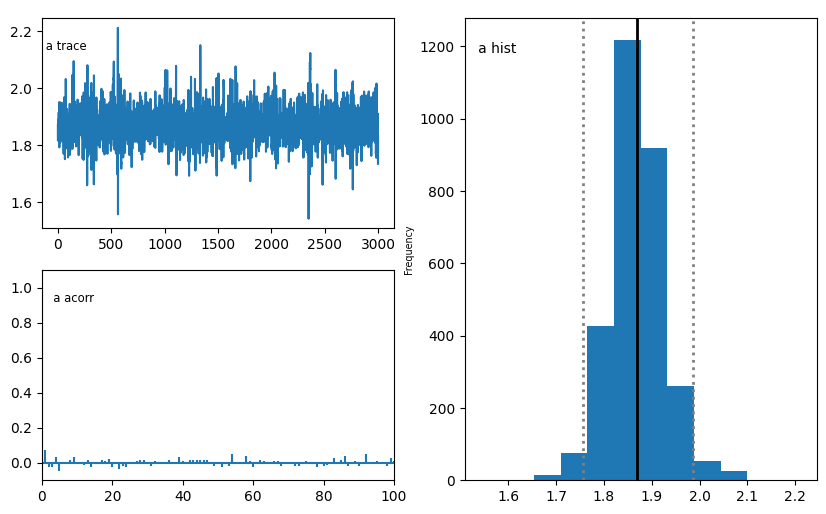

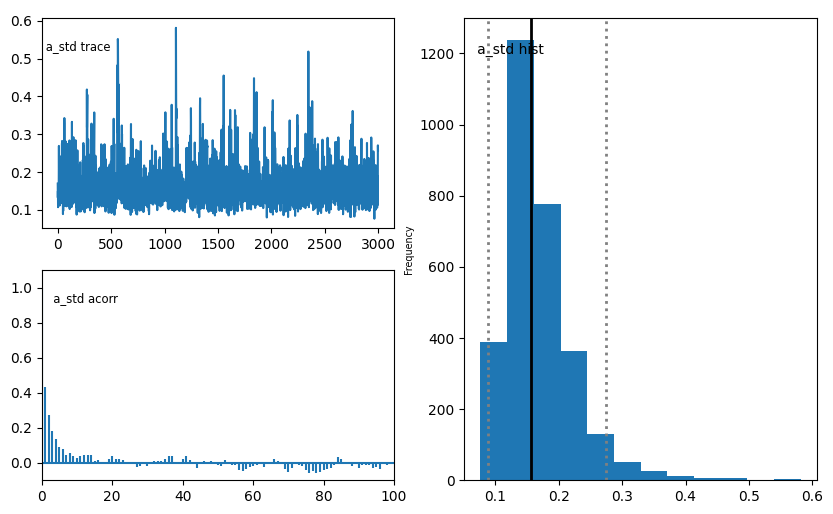

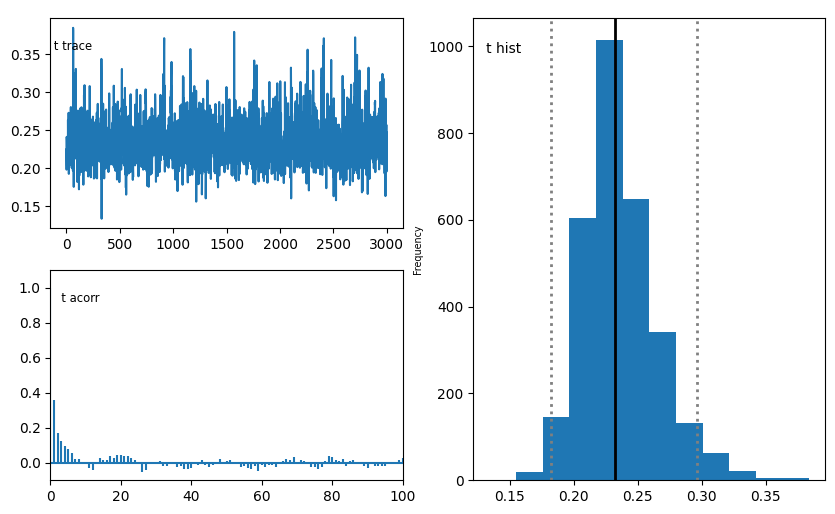

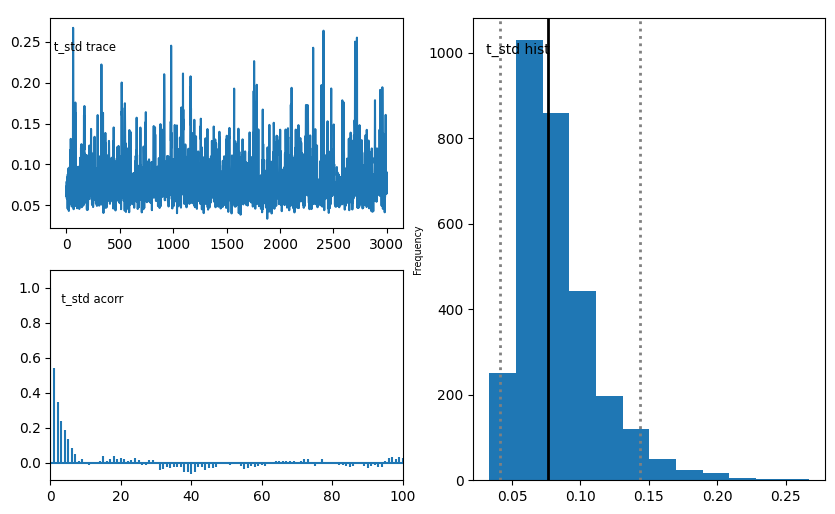

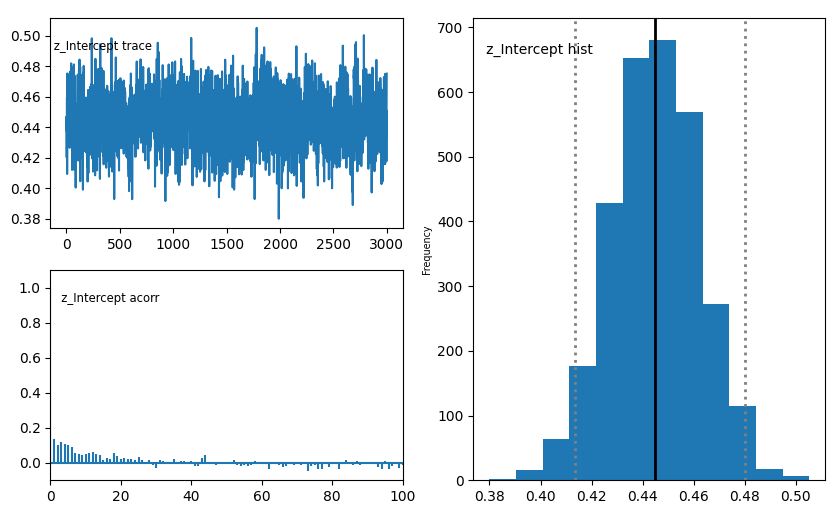

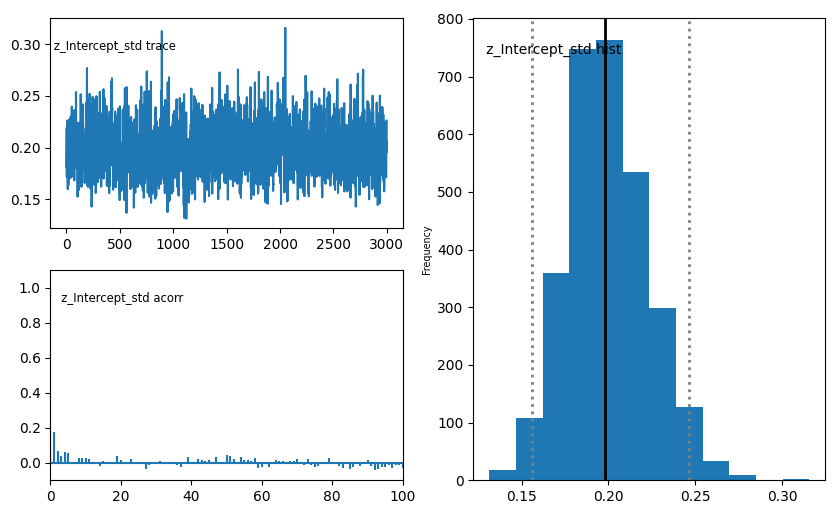

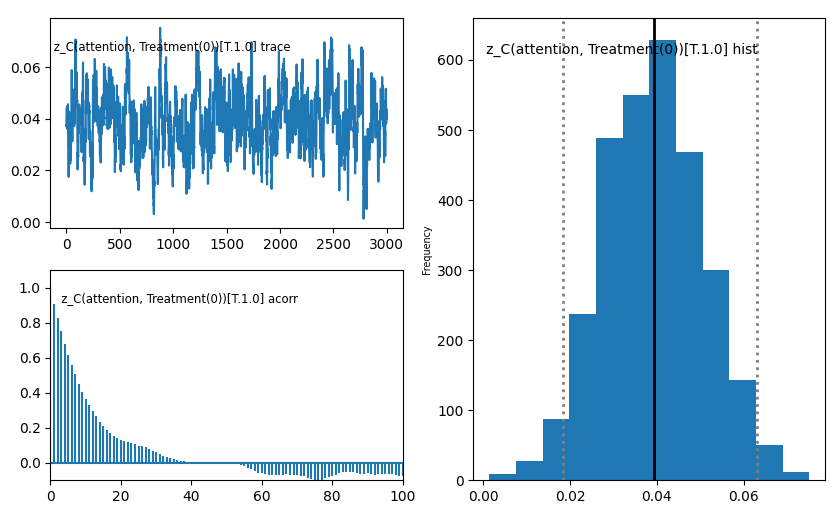

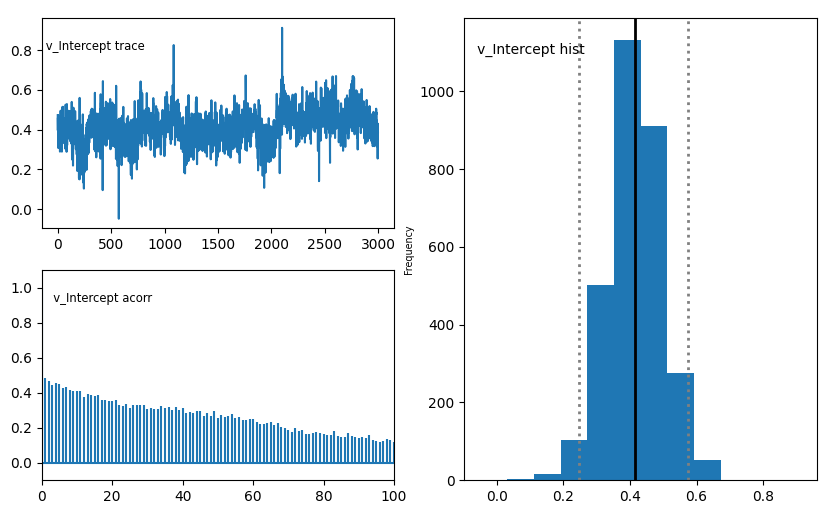

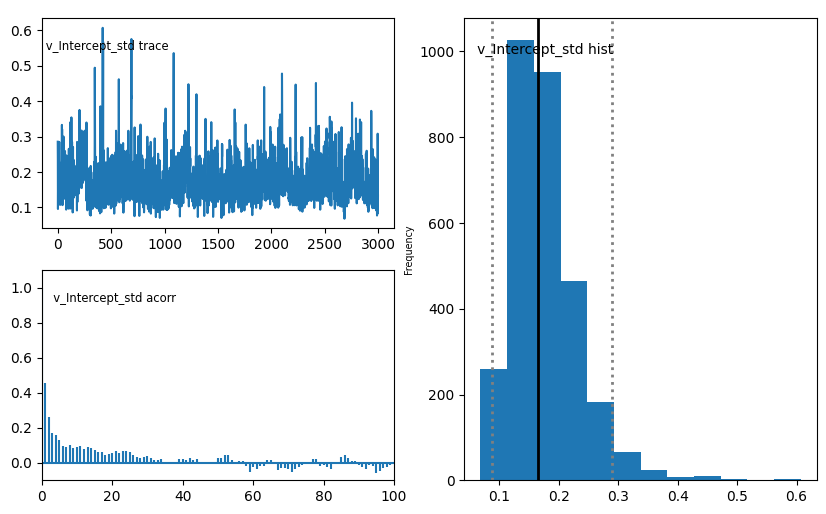

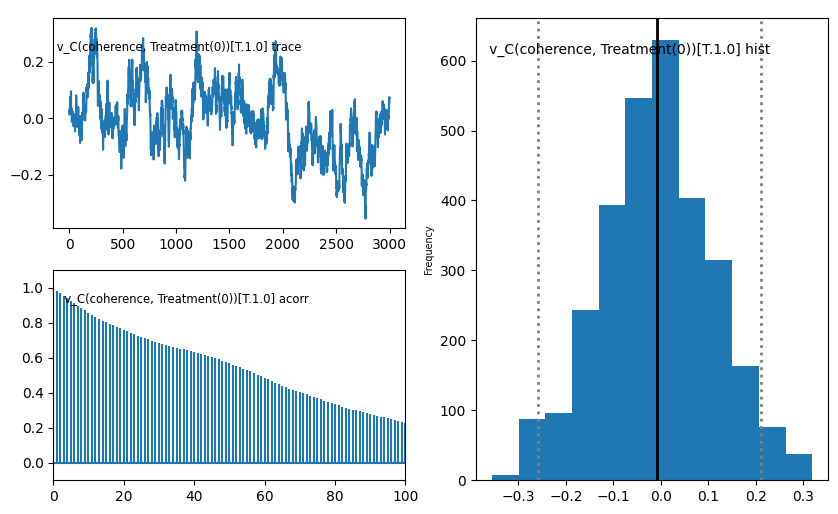

In [30]:
m_reg3.plot_posteriors()

<font face="Times New Roman" size=5> 5.with z link func with more runs. </font>

In [32]:
# The link function for ``z`` is:
z_reg = {'model': "z ~ 1 + C(attention,Treatment(0))", 'link_func': z_link_func}
# The link function for ``v`` is:
v_reg = {'model': "v ~ 1 + C(coherence,Treatment(0))", 'link_func': lambda x:x}
# Then we can put the regression description for the hddm model.
reg_descr = [z_reg, v_reg]
# Finally we run the regression model 
m_reg3 = hddm.HDDMRegressor(data, 
                            reg_descr,
                            include=['z'],       
                            p_outlier=.05)
m_reg3.find_starting_values()
m_reg3.sample(4000,burn=1000)

Adding these covariates:
['z_Intercept', 'z_C(attention, Treatment(0))[T.1.0]']
Adding these covariates:
['v_Intercept', 'v_C(coherence, Treatment(0))[T.1.0]']


/home/yikang1020/anaconda3/envs/hddm38/lib/python3.8/site-packages/scipy/optimize/optimize.py:2116: RuntimeWarning: invalid value encountered in double_scalars
  tmp2 = (x - v) * (fx - fw)
/home/yikang1020/anaconda3/envs/hddm38/lib/python3.8/site-packages/scipy/optimize/optimize.py:2116: RuntimeWarning: invalid value encountered in double_scalars
  tmp2 = (x - v) * (fx - fw)
/home/yikang1020/anaconda3/envs/hddm38/lib/python3.8/site-packages/scipy/optimize/optimize.py:2116: RuntimeWarning: invalid value encountered in double_scalars
  tmp2 = (x - v) * (fx - fw)
/home/yikang1020/anaconda3/envs/hddm38/lib/python3.8/site-packages/scipy/optimize/optimize.py:2116: RuntimeWarning: invalid value encountered in double_scalars
  tmp2 = (x - v) * (fx - fw)
/home/yikang1020/anaconda3/envs/hddm38/lib/python3.8/site-packages/scipy/optimize/optimize.py:2116: RuntimeWarning: invalid value encountered in double_scalars
  tmp2 = (x - v) * (fx - fw)
/home/yikang1020/anaconda3/envs/hddm38/lib/python3.8/si

 [-----------------100%-----------------] 4001 of 4000 complete in 3233.2 sec

Plotting a
Plotting a_std
Plotting t
Plotting t_std
Plotting z_Intercept
Plotting z_Intercept_std
Plotting z_C(attention, Treatment(0))[T.1.0]
Plotting v_Intercept
Plotting v_Intercept_std
Plotting v_C(coherence, Treatment(0))[T.1.0]


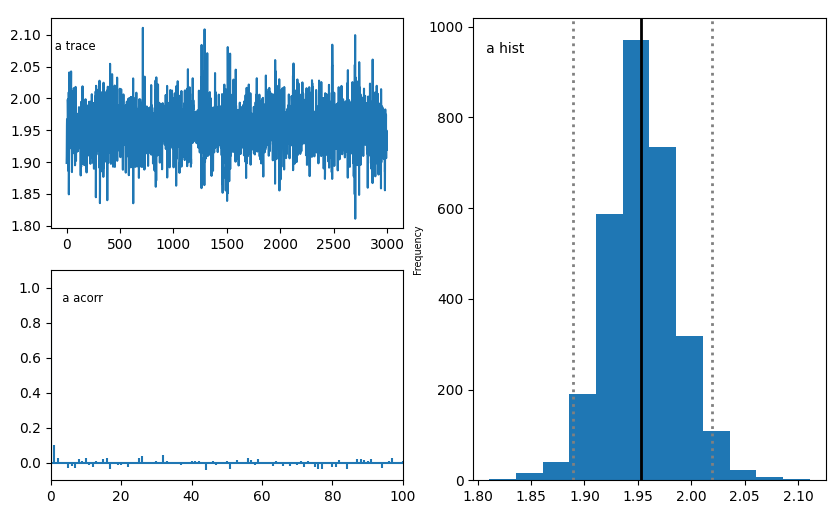

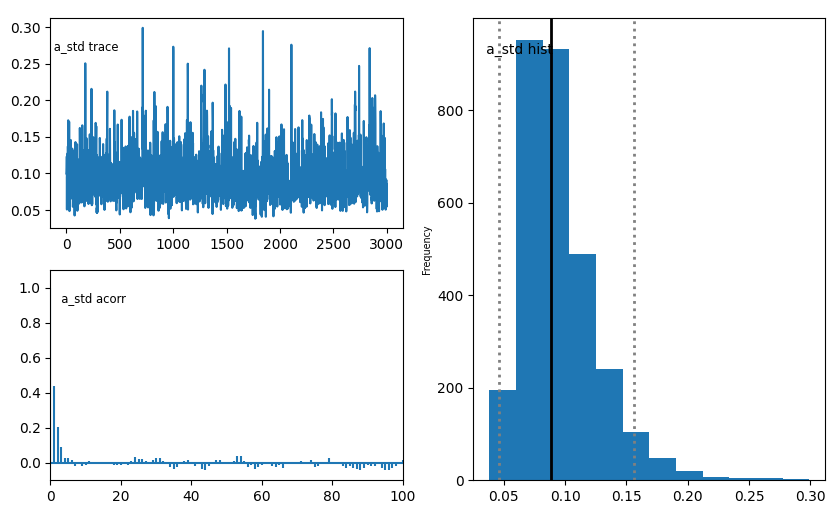

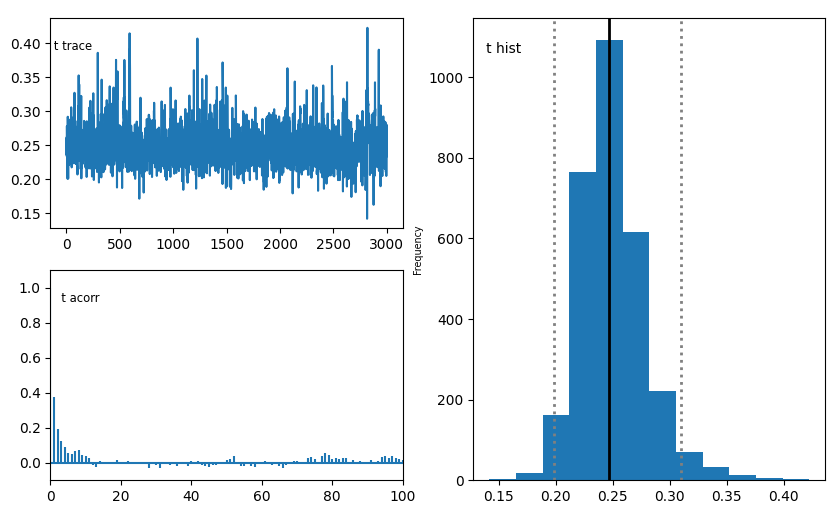

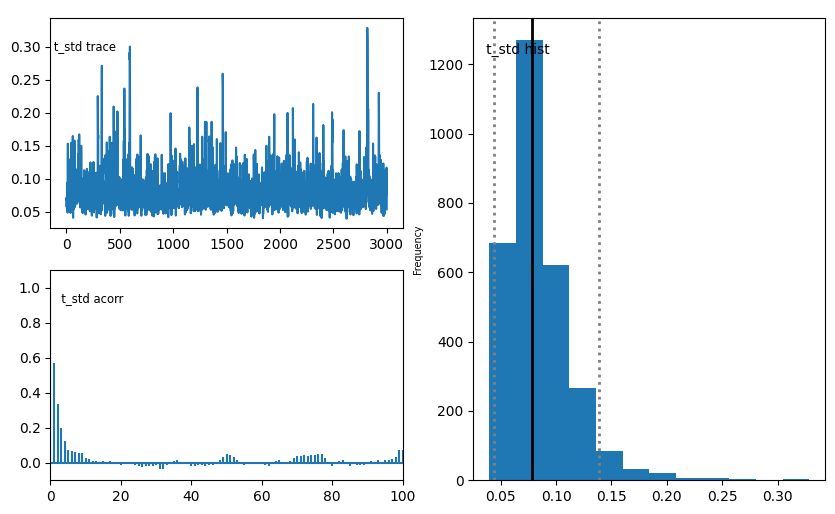

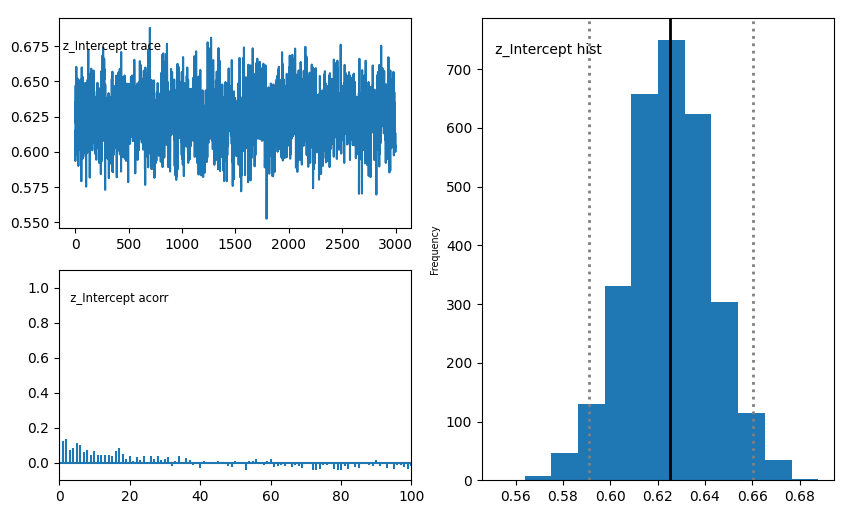

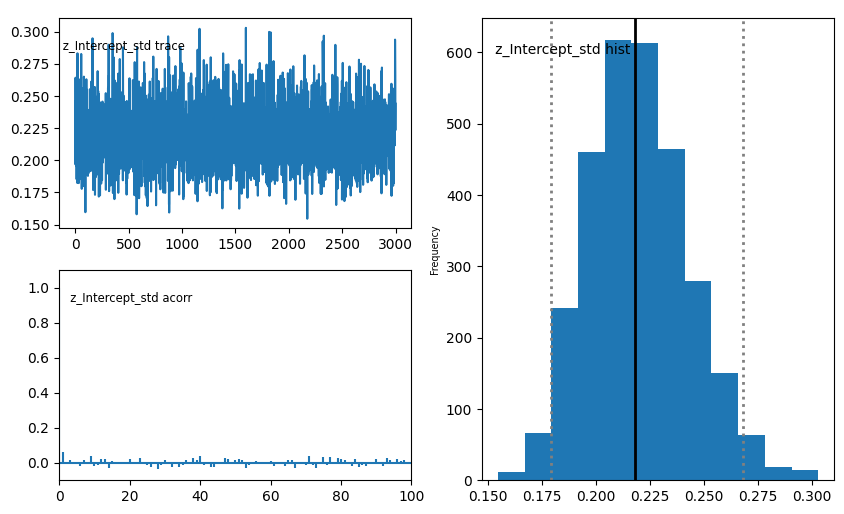

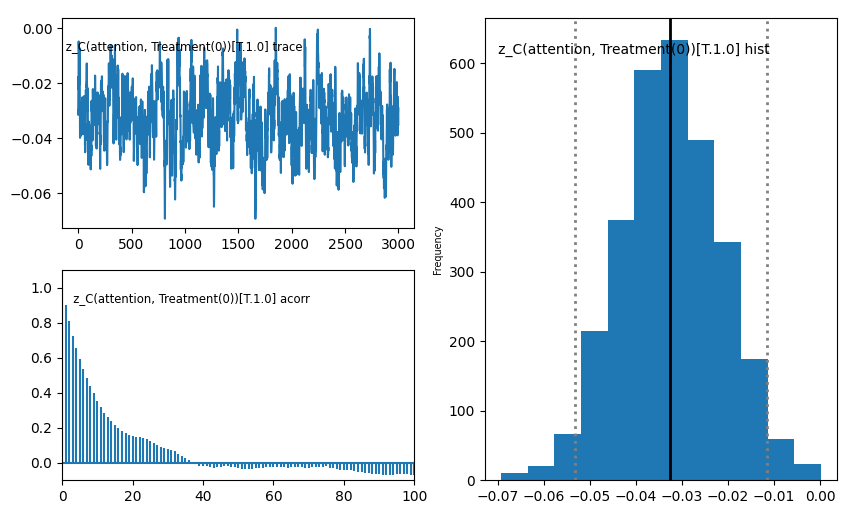

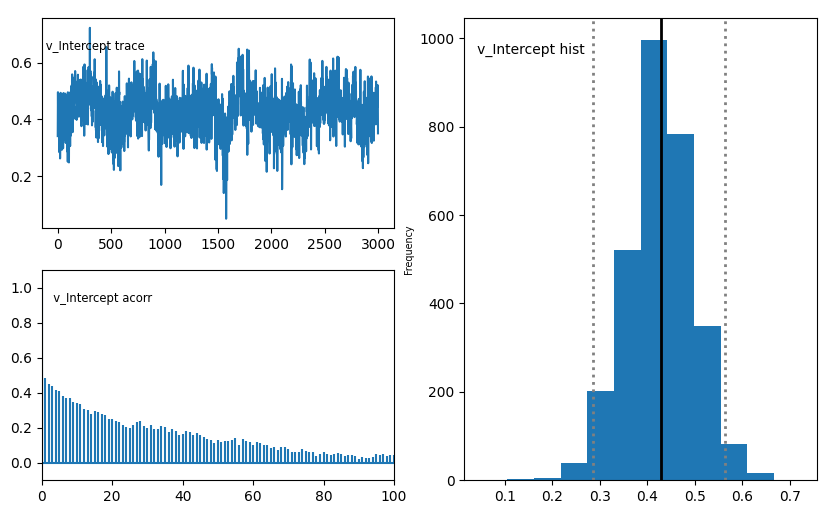

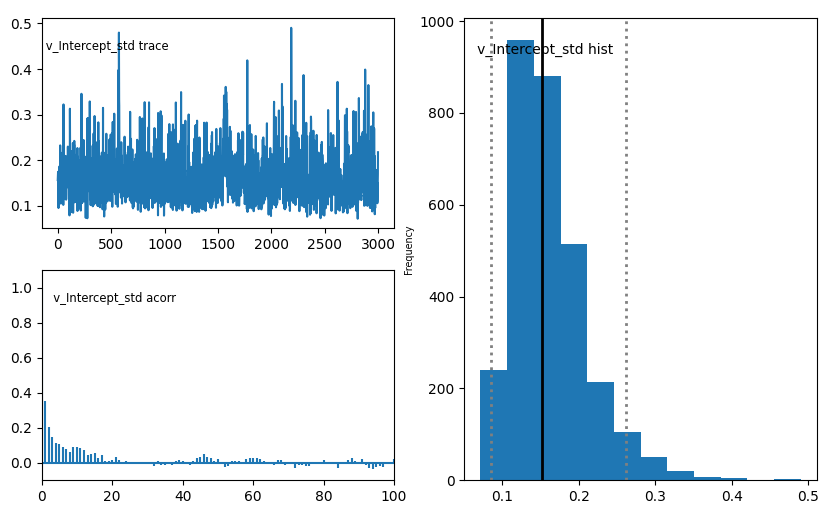

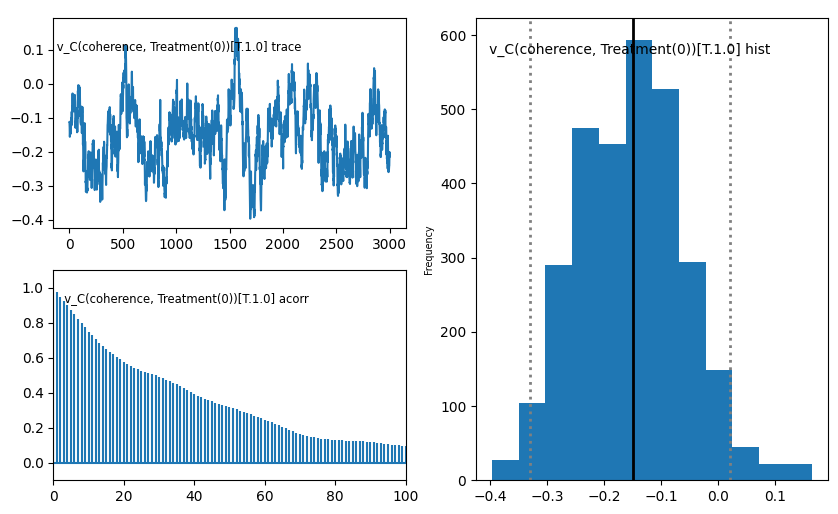

In [33]:
m_reg3.plot_posteriors()

In [34]:
m_reg3.gen_stats()

mean       std      2.5q       25q  \
a                                    1.953892  0.033219  1.889492  1.933389   
a_std                                0.095074  0.031244  0.052803  0.073488   
a_subj.0                             1.853244  0.026609  1.803623  1.835111   
a_subj.1                             1.934405  0.027726  1.880429  1.915387   
a_subj.2                              1.89987  0.028874  1.845793  1.880215   
a_subj.3                             2.063987   0.02994  2.006048  2.043239   
a_subj.4                             1.902702  0.026553  1.852297  1.884374   
a_subj.5                             1.870582   0.02846  1.815692   1.85131   
a_subj.6                              2.03046  0.029687  1.972444  2.010532   
a_subj.7                             1.932522  0.027796  1.876338  1.915131   
a_subj.8                             2.042868   0.02956  1.986964  2.022144   
a_subj.9                             2.003881  0.034196   1.93784  1.980472   
t                                    0.249929  0.029054  0.202614  0.230978   
t_std                                0.084821  0.030182  0.048489  0.064967   
t_subj.0                             0.240661  0.007113  0.226672    0.2361   
t_subj.1                             0.185351  0.004113  0.176853  0.182626   
t_subj.2                             0.246863  0.007223  0.232012  0.242202   
t_subj.3                             0.310254  0.007539  0.295703  0.305216   
t_subj.4                             0.223283  0.003181   0.21648  0.221278   
t_subj.5                             0.281356  0.008299  0.265934  0.275644   
t_subj.6                             0.211622  0.007099   0.19746  0.207056   
t_subj.7                             0.234311  0.007399  0.219396  0.229419   
t_subj.8                             0.115928  0.007399  0.100828  0.111008   
t_subj.9                             0.345919  0.002365  0.340957  0.344345   
z_Intercept                          0.625127  0.017609  0.590117  0.613554   
z_Intercept_std                      0.219764  0.023031   0.17857  0.203577   
z_Intercept_subj.0                   0.624754  0.013638  0.598785  0.615602   
z_Intercept_subj.1                   0.704038  0.013124  0.678267  0.695063   
z_Intercept_subj.2                   0.506036  0.009885  0.487479  0.499241   
z_Intercept_subj.3                   0.600717  0.008573   0.58376  0.595088   
z_Intercept_subj.4                   0.708606  0.007406  0.693909  0.703726   
z_Intercept_subj.5                   0.591124  0.014004  0.562446  0.582217   
z_Intercept_subj.6                   0.641058  0.013356   0.61472  0.632479   
z_Intercept_subj.7                   0.521951  0.010194  0.502201  0.514933   
z_Intercept_subj.8                   0.572253  0.008652  0.554854  0.566542   
z_Intercept_subj.9                   0.770544   0.00648  0.757643  0.766094   
z_C(attention, Treatment(0))[T.1.0] -0.032353  0.010975 -0.052855 -0.039455   
v_Intercept                          0.428057   0.07068  0.288124  0.384432   
v_Intercept_std                      0.161695  0.049722  0.094415  0.127347   
v_Intercept_subj.0                   0.306524   0.09661   0.11531  0.242626   
v_Intercept_subj.1                   0.368263  0.097407  0.178436  0.301429   
v_Intercept_subj.2                   0.715147   0.09656  0.527082  0.651224   
v_Intercept_subj.3                   0.469147  0.097028  0.272342  0.403321   
v_Intercept_subj.4                   0.232833   0.09805  0.041505  0.170331   
v_Intercept_subj.5                   0.402523  0.033283  0.336861  0.380366   
v_Intercept_subj.6                   0.391728  0.030459  0.331154  0.372073   
v_Intercept_subj.7                   0.431504  0.032431   0.36796  0.410233   
v_Intercept_subj.8                     0.4676   0.03128    0.4063  0.446987   
v_Intercept_subj.9                   0.477029   0.03781  0.403395  0.452138   
v_C(coherence, Treatment(0))[T.1.0] -0.152633  0.093591 -0.322305 -0.223944   

           

<font face="Times New Roman" size=5> 6.with z link func and z change with levels. </font>

In [11]:
data = rawdata

In [12]:
# The link function for ``z`` is:
z_reg = {'model': "z ~ 1 + C(condition)", 'link_func': z_link_func}
# The link function for ``v`` is:
v_reg = {'model': "v ~ 1 + C(condition)", 'link_func': lambda x:x}
# Then we can put the regression description for the hddm model.
reg_descr = [z_reg, v_reg]
# Finally we run the regression model 
m_reg4 = hddm.HDDMRegressor(data, 
                            reg_descr,
                            group_only_regressors=True,
                            include=['z'],       
                            p_outlier=.05)
m_reg4.find_starting_values()
m_reg4.sample(8000,burn=4000)

Adding these covariates:
['z_Intercept', 'z_C(condition)[T.level2]', 'z_C(condition)[T.level3]', 'z_C(condition)[T.level4]']
Adding these covariates:
['v_Intercept', 'v_C(condition)[T.level2]', 'v_C(condition)[T.level3]', 'v_C(condition)[T.level4]']


/home/yikang1020/anaconda3/envs/hddm38/lib/python3.8/site-packages/scipy/optimize/optimize.py:2116: RuntimeWarning: invalid value encountered in double_scalars
  tmp2 = (x - v) * (fx - fw)
/home/yikang1020/anaconda3/envs/hddm38/lib/python3.8/site-packages/scipy/optimize/optimize.py:2116: RuntimeWarning: invalid value encountered in double_scalars
  tmp2 = (x - v) * (fx - fw)
/home/yikang1020/anaconda3/envs/hddm38/lib/python3.8/site-packages/scipy/optimize/optimize.py:2116: RuntimeWarning: invalid value encountered in double_scalars
  tmp2 = (x - v) * (fx - fw)
/home/yikang1020/anaconda3/envs/hddm38/lib/python3.8/site-packages/scipy/optimize/optimize.py:2116: RuntimeWarning: invalid value encountered in double_scalars
  tmp2 = (x - v) * (fx - fw)
/home/yikang1020/anaconda3/envs/hddm38/lib/python3.8/site-packages/scipy/optimize/optimize.py:2116: RuntimeWarning: invalid value encountered in double_scalars
  tmp2 = (x - v) * (fx - fw)
/home/yikang1020/anaconda3/envs/hddm38/lib/python3.8/si

 [-----------------100%-----------------] 8001 of 8000 complete in 10982.0 sec

Plotting a
Plotting a_std
Plotting t
Plotting t_std
Plotting z_Intercept
Plotting z_Intercept_std
Plotting z_C(condition)[T.level2]
Plotting z_C(condition)[T.level3]
Plotting z_C(condition)[T.level4]
Plotting v_Intercept
Plotting v_Intercept_std
Plotting v_C(condition)[T.level2]
Plotting v_C(condition)[T.level3]
Plotting v_C(condition)[T.level4]


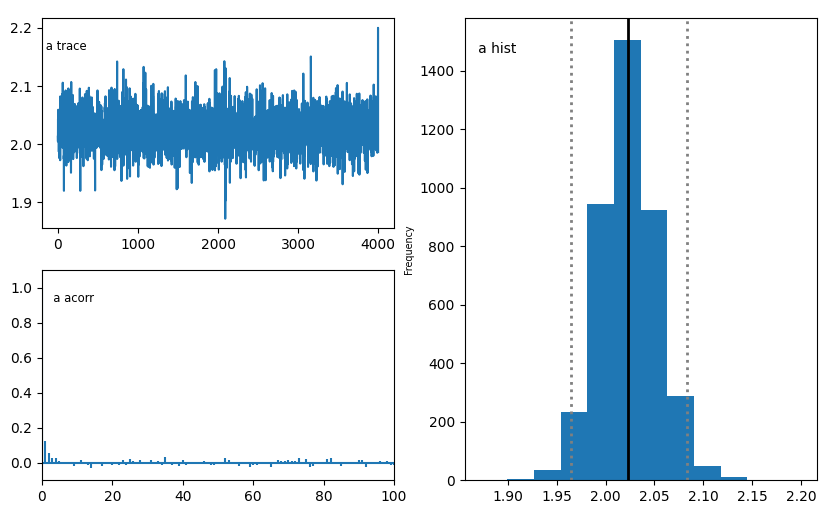

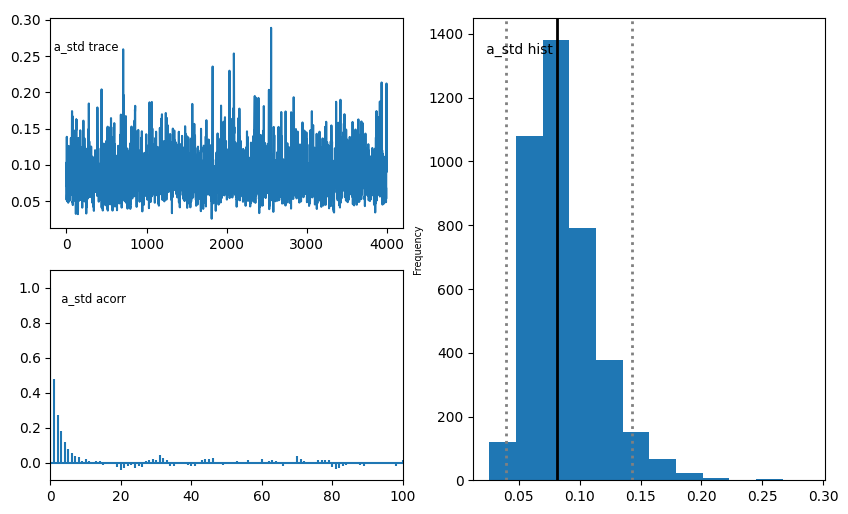

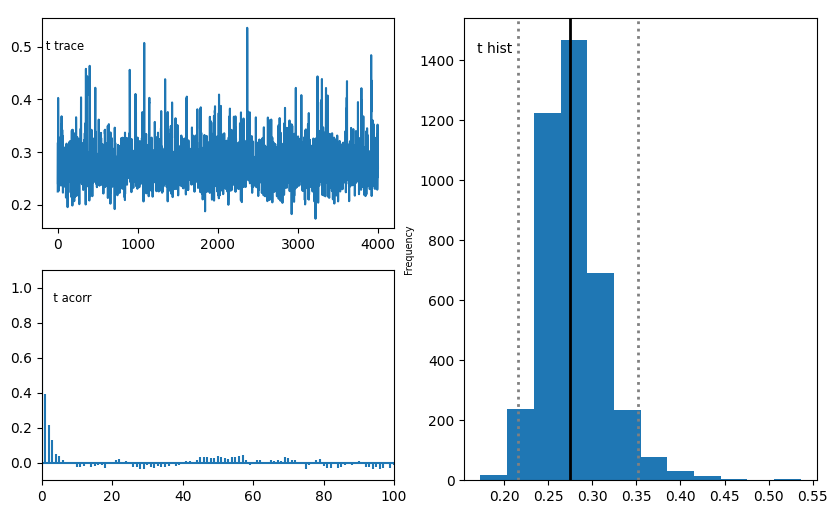

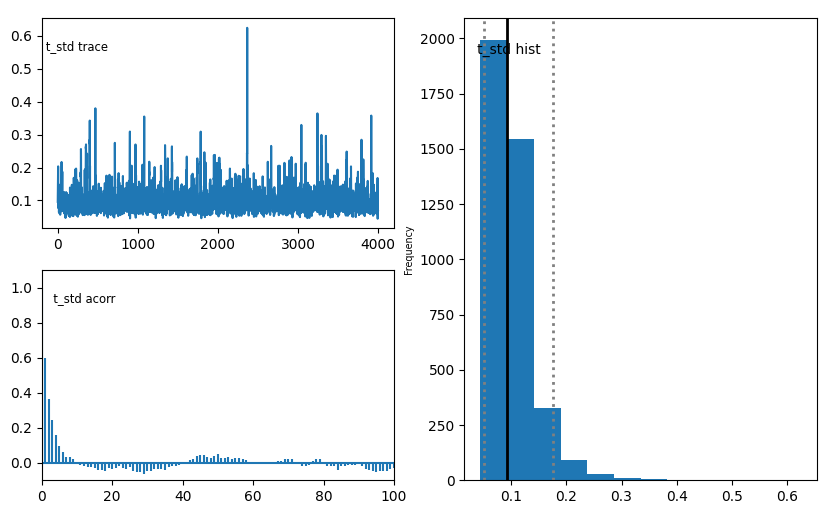

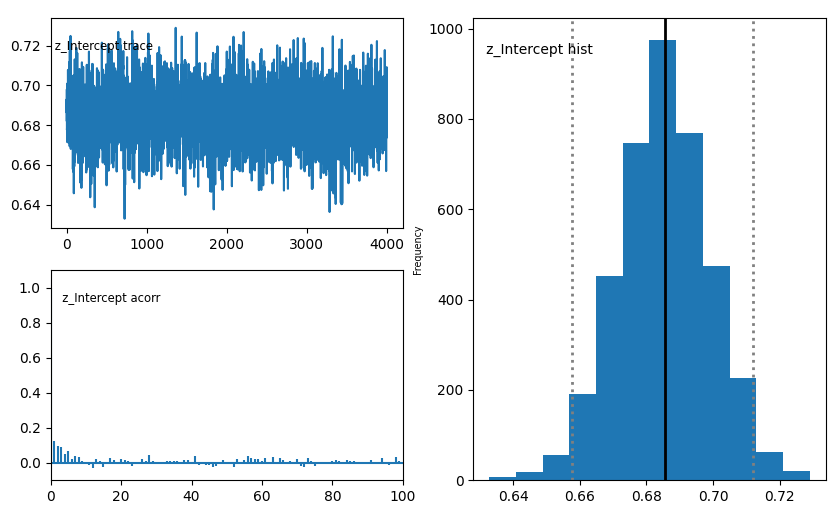

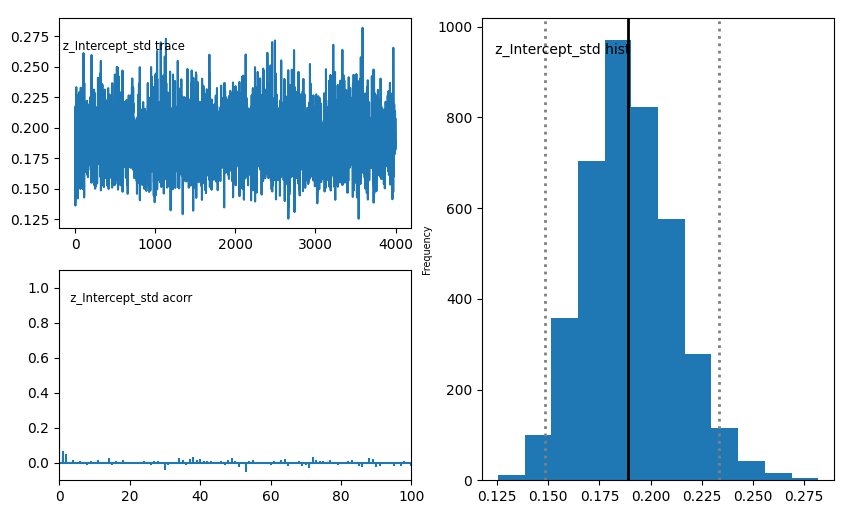

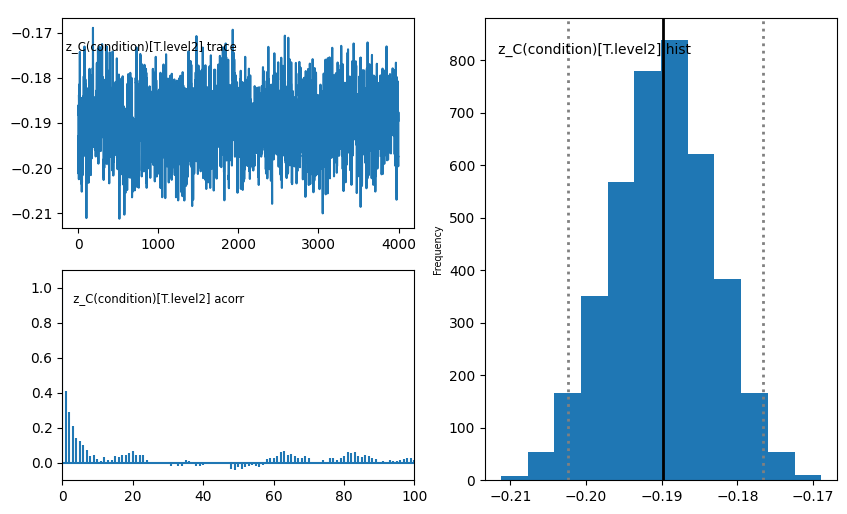

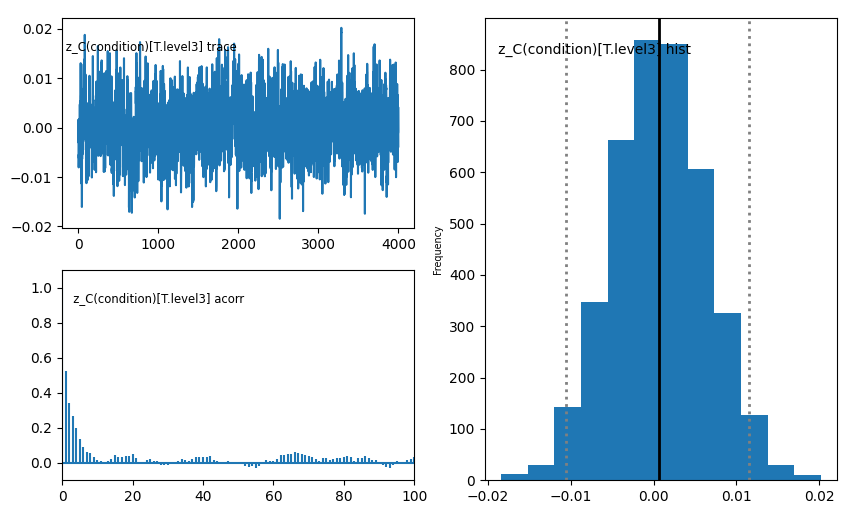

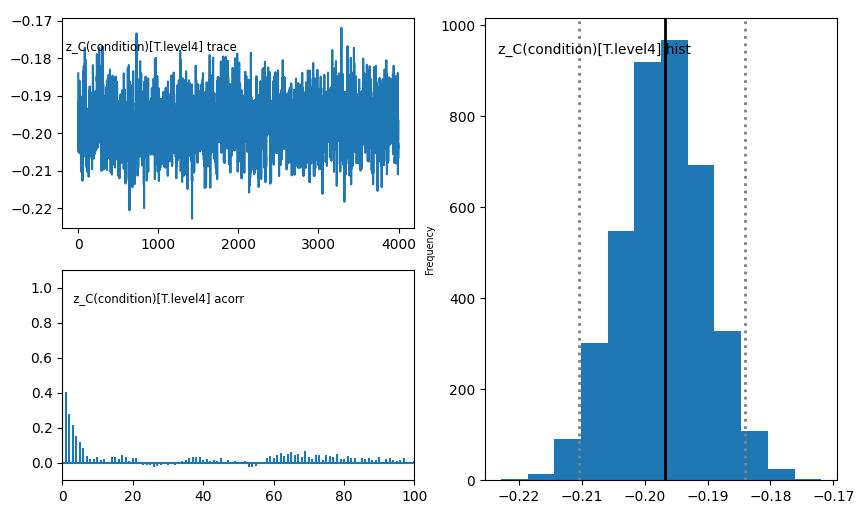

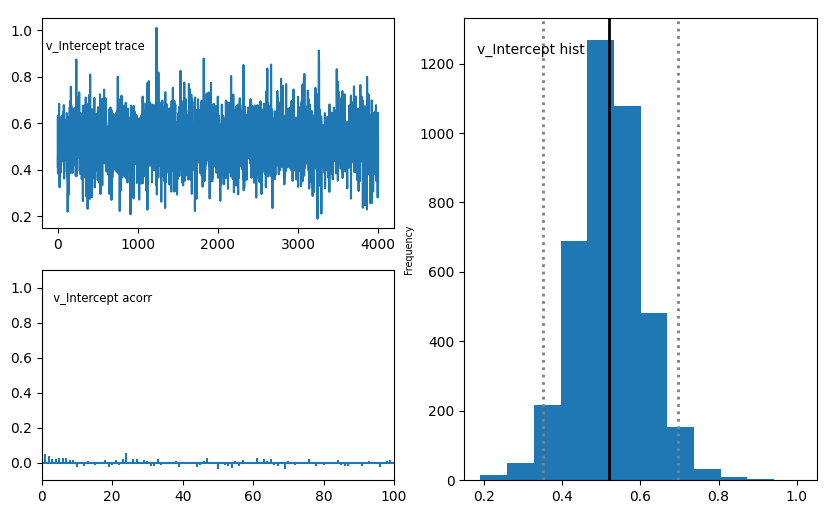

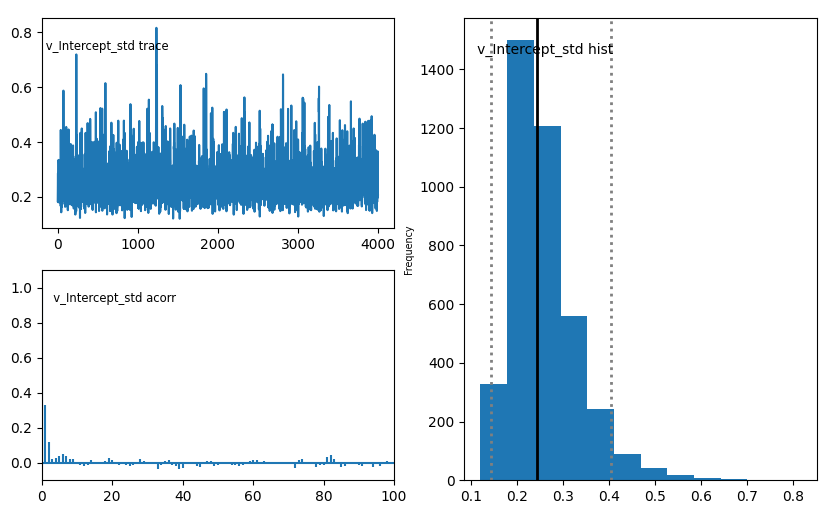

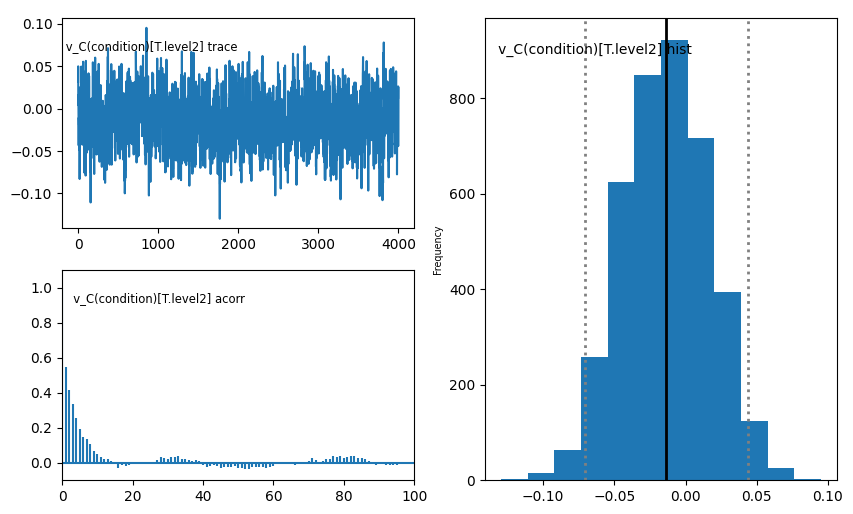

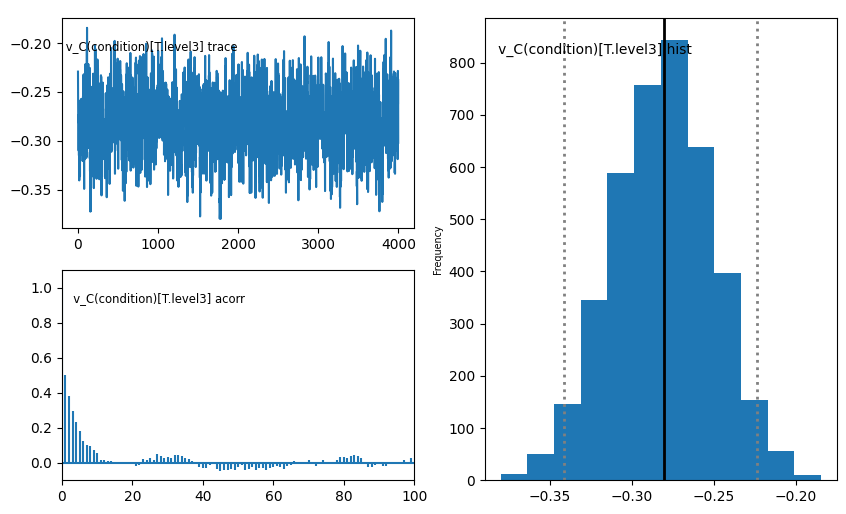

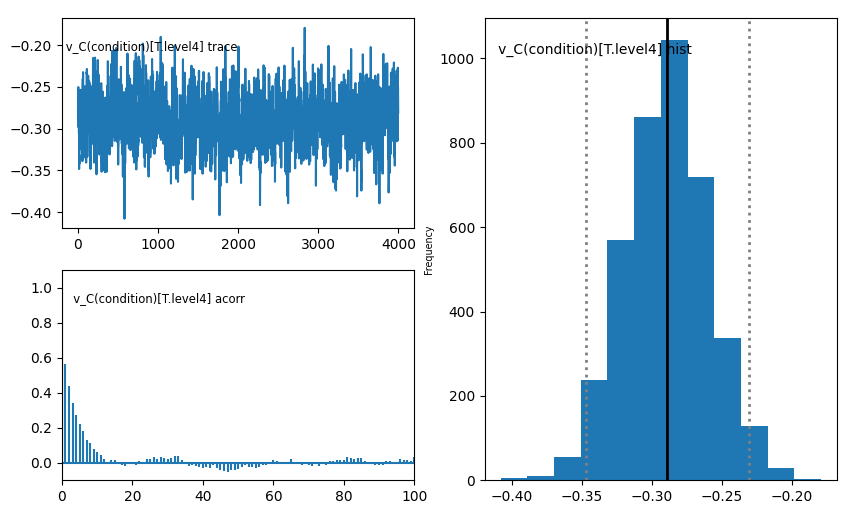

In [16]:
m_reg4.plot_posteriors()

In [14]:
m_reg4.gen_stats()

mean       std      2.5q       25q       50q  \
a                         2.023515  0.029736  1.964919  2.004478  2.023029   
a_std                     0.086548  0.028635  0.046588  0.066731  0.081091   
a_subj.0                  2.064157  0.029063  2.008692  2.045043  2.063644   
a_subj.1                  1.994723  0.033042  1.931969  1.971587  1.994313   
a_subj.2                  1.922389  0.027936  1.868143  1.903694  1.921506   
a_subj.3                  1.964332  0.027217  1.911001  1.945529  1.964389   
a_subj.4                  2.036094  0.027171  1.985314  2.017547  2.035545   
a_subj.5                   2.00268  0.028921  1.945729  1.982845  2.002372   
a_subj.6                  2.176857  0.041413  2.101109  2.147934  2.174524   
a_subj.7                  1.981013  0.028226  1.926276  1.962099  1.980974   
a_subj.8                  2.032476  0.028868  1.977512  2.012653  2.031917   
a_subj.9                  2.057907  0.030827  1.998273  2.037335  2.057812   
t                         0.278663  0.036107  0.221438  0.255156  0.274414   
t_std                     0.101787  0.039648  0.056817  0.076628  0.092906   
t_subj.0                  0.294237  0.005523  0.281555  0.291126  0.294791   
t_subj.1                  0.306792  0.007849  0.288322  0.302368  0.307701   
t_subj.2                  0.265759   0.00596  0.253709   0.26178  0.266031   
t_subj.3                  0.266063   0.00602  0.253837  0.261936  0.266424   
t_subj.4                  0.343337  0.003896  0.334839   0.34089  0.343547   
t_subj.5                  0.341981  0.006463  0.329939  0.336577  0.342993   
t_subj.6                   0.10692  0.011993  0.077621  0.102126  0.110896   
t_subj.7                  0.255824  0.007891  0.241604  0.250308   0.25534   
t_subj.8                  0.267854  0.007481  0.252475  0.262966  0.268241   
t_subj.9                   0.20477  0.005451  0.195725  0.201371   0.20452   
z_Intercept               0.685288  0.013776  0.657694  0.676284  0.685451   
z_Intercept_std           0.190207     0.022  0.150699  0.174941  0.188921   
z_Intercept_subj.0        0.720159  0.008434  0.703244  0.714467  0.720295   
z_Intercept_subj.1         0.67146  0.008552  0.654799  0.665705  0.671643   
z_Intercept_subj.2        0.631411  0.008724   0.61471  0.625505  0.631362   
z_Intercept_subj.3        0.666774   0.00847  0.649773  0.661298  0.666656   
z_Intercept_subj.4        0.762939  0.008231  0.747214   0.75723  0.763168   
z_Intercept_subj.5        0.741191  0.008093  0.725488  0.735588  0.741314   
z_Intercept_subj.6        0.719345  0.009083  0.701221  0.713312    0.7195   
z_Intercept_subj.7        0.557638  0.008695  0.540366  0.551778  0.557717   
z_Intercept_subj.8        0.635048  0.008842  0.618114  0.629042  0.635026   
z_Intercept_subj.9        0.742482  0.007932   0.72644  0.737218  0.742591   
z_C(condition)[T.level2] -0.189923  0.006623 -0.202935 -0.194425 -0.189802   
z_C(condition)[T.level3]  0.000716  0.005688 -0.010283 -0.003168  0.000665   
z_C(condition)[T.level4] -0.196943  0.006809 -0.210294 -0.201436  -0.19683   
v_Intercept               0.521418  0.088768  0.347868  0.464894  0.520331   
v_Intercept_std           0.258087  0.074532  0.156728  0.207631  0.242986   
v_Intercept_subj.0        0.460054   0.03753  0.385478  0.434723  0.460486   
v_Intercept_subj.1        0.856826  0.041829  0.775949  0.828567  0.856911   
v_Intercept_subj.2        0.561098  0.039026   0.48289  0.535087  0.561643   
v_Intercept_subj.3        0.541287   0.03753  0.467635  0.515694  0.541596   
v_Intercept_subj.4        0.064347  0.038111 -0.009079  0.038948  0.063984   
v_Intercept_subj.5        0.427117  0.038472  0.350889  0.401687   0.42738   
v_Intercept_subj.6        0.782919  0.038563  0.707732  0.756178  0.783217   
v_Intercept_subj.7        0.387432  0.037323  0.313456   0.36214  0.387733   
v_Intercept_subj.8        0.537607  0.036433  0.466577  0.513168  0.537272   
v_Intercept_subj.9        0.582649   0.03905  0.5072

In [15]:
m_reg4.dic

32405.130042666493

In [17]:
data

rt  response  subj_idx condition  stimulus  coherence  attention
0      0.712462       1.0         0    level1       0.0        1.0        1.0
1      0.840036       1.0         0    level1       0.0        1.0        1.0
2      1.532637       1.0         0    level1       0.0        1.0        1.0
3      1.131339       1.0         0    level1       0.0        1.0        1.0
4      0.942794       0.0         0    level1       0.0        1.0        1.0
...         ...       ...       ...       ...       ...        ...        ...
11995  1.240447       0.0         9    level4       1.0        0.0        0.0
11996  0.681809       1.0         9    level4       1.0        0.0        0.0
11997  1.885085       1.0         9    level4       1.0        0.0        0.0
11998  0.311386       0.0         9    level4       1.0        0.0        0.0
11999  3.180781       0.0         9    level4       1.0        0.0        0.0

[12000 rows x 7 columns]

In [19]:
# The link function for ``z`` is:
z_reg = {'model': "z ~ 1 + C(condition)", 'link_func': z_link_func}
# The link function for ``v`` is:
v_reg = {'model': "v ~ 1 + C(condition)", 'link_func': lambda x:x}
# Then we can put the regression description for the hddm model.
reg_descr = [z_reg, v_reg]
# Finally we run the regression model 
m_reg4 = hddm.HDDMRegressor(data, 
                            reg_descr,
                            group_only_regressors=True,
                            include=['z'],       
                            p_outlier=.05)
m_reg4.find_starting_values()
m_reg4.sample(2000,burn=1000)

Adding these covariates:
['z_Intercept', 'z_C(condition)[T.level2]', 'z_C(condition)[T.level3]', 'z_C(condition)[T.level4]']
Adding these covariates:
['v_Intercept', 'v_C(condition)[T.level2]', 'v_C(condition)[T.level3]', 'v_C(condition)[T.level4]']


/home/yikang1020/anaconda3/envs/hddm38/lib/python3.8/site-packages/scipy/optimize/optimize.py:2116: RuntimeWarning: invalid value encountered in double_scalars
  tmp2 = (x - v) * (fx - fw)
/home/yikang1020/anaconda3/envs/hddm38/lib/python3.8/site-packages/scipy/optimize/optimize.py:2116: RuntimeWarning: invalid value encountered in double_scalars
  tmp2 = (x - v) * (fx - fw)
/home/yikang1020/anaconda3/envs/hddm38/lib/python3.8/site-packages/scipy/optimize/optimize.py:2116: RuntimeWarning: invalid value encountered in double_scalars
  tmp2 = (x - v) * (fx - fw)
/home/yikang1020/anaconda3/envs/hddm38/lib/python3.8/site-packages/scipy/optimize/optimize.py:2116: RuntimeWarning: invalid value encountered in double_scalars
  tmp2 = (x - v) * (fx - fw)
/home/yikang1020/anaconda3/envs/hddm38/lib/python3.8/site-packages/scipy/optimize/optimize.py:2116: RuntimeWarning: invalid value encountered in double_scalars
  tmp2 = (x - v) * (fx - fw)
/home/yikang1020/anaconda3/envs/hddm38/lib/python3.8/si

 [-----------------100%-----------------] 2001 of 2000 complete in 2716.7 sec

Plotting a
Plotting a_std
Plotting t
Plotting t_std
Plotting z_Intercept
Plotting z_Intercept_std
Plotting z_C(condition)[T.level2]
Plotting z_C(condition)[T.level3]
Plotting z_C(condition)[T.level4]
Plotting v_Intercept
Plotting v_Intercept_std
Plotting v_C(condition)[T.level2]
Plotting v_C(condition)[T.level3]
Plotting v_C(condition)[T.level4]


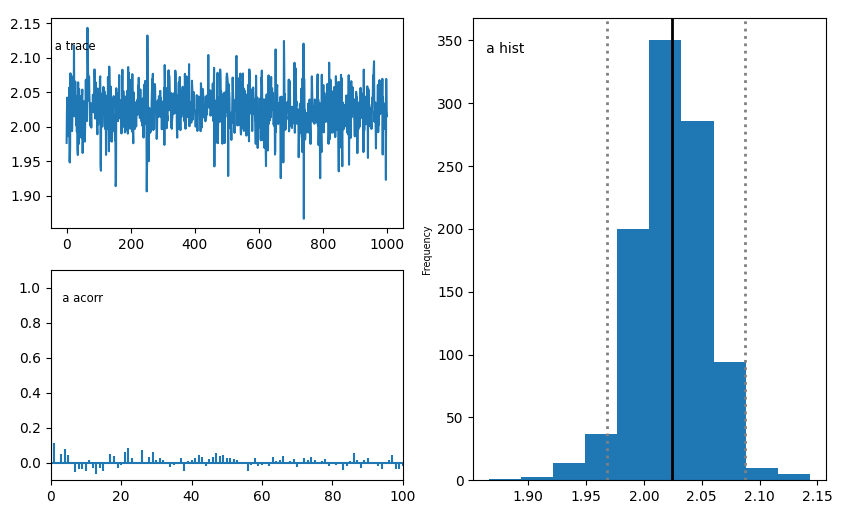

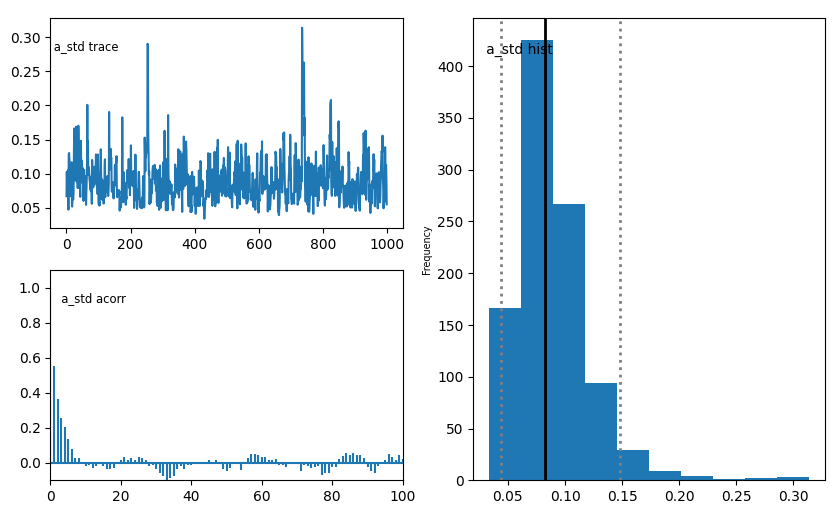

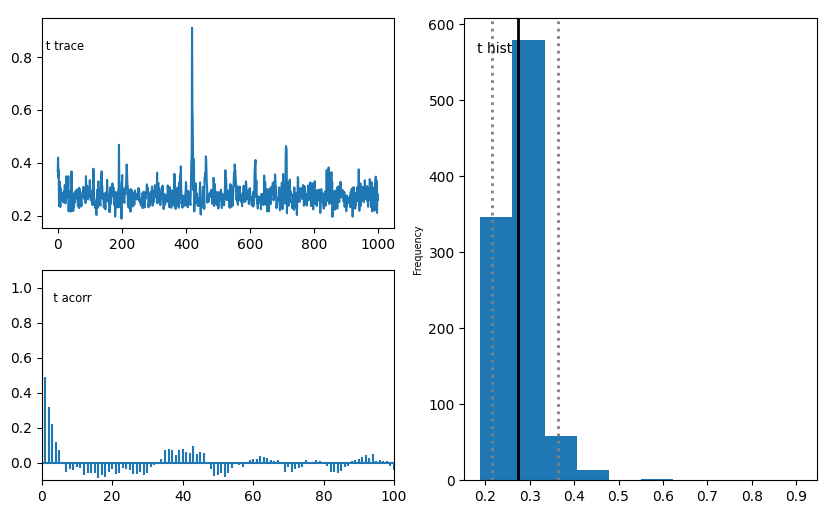

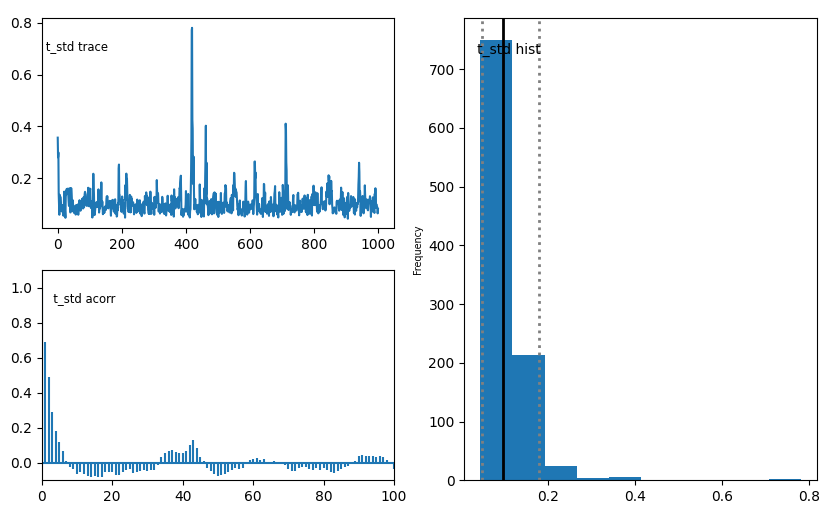

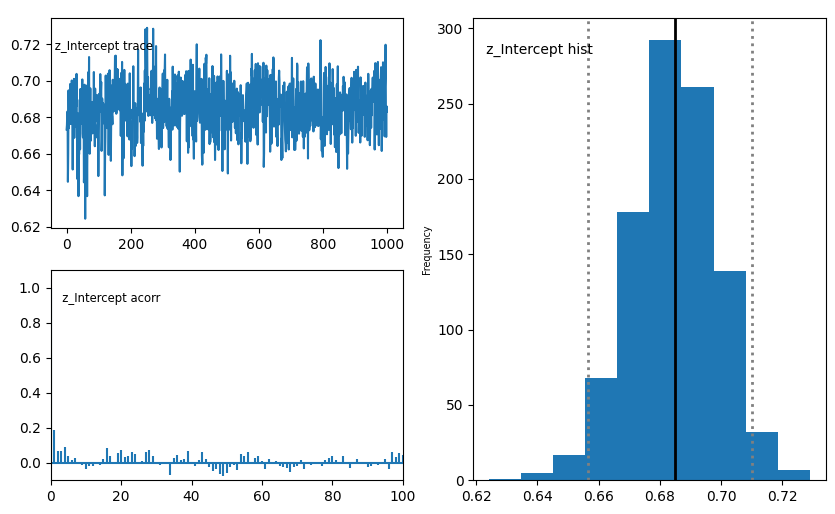

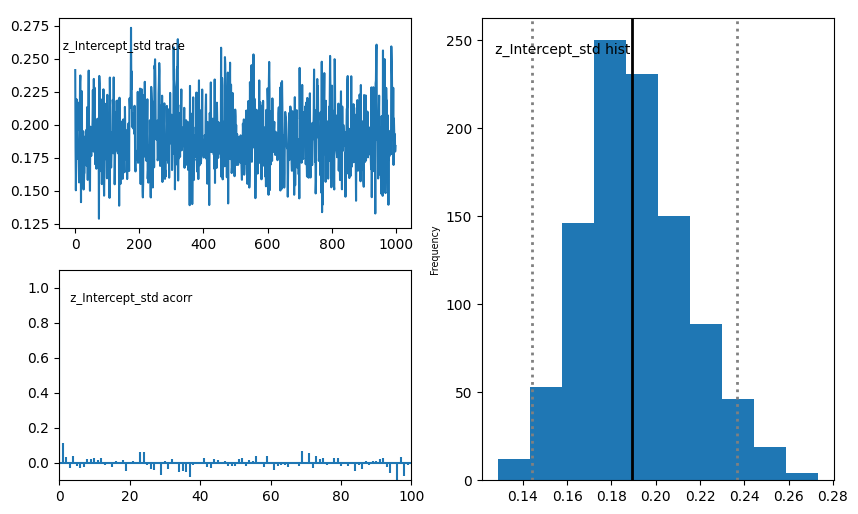

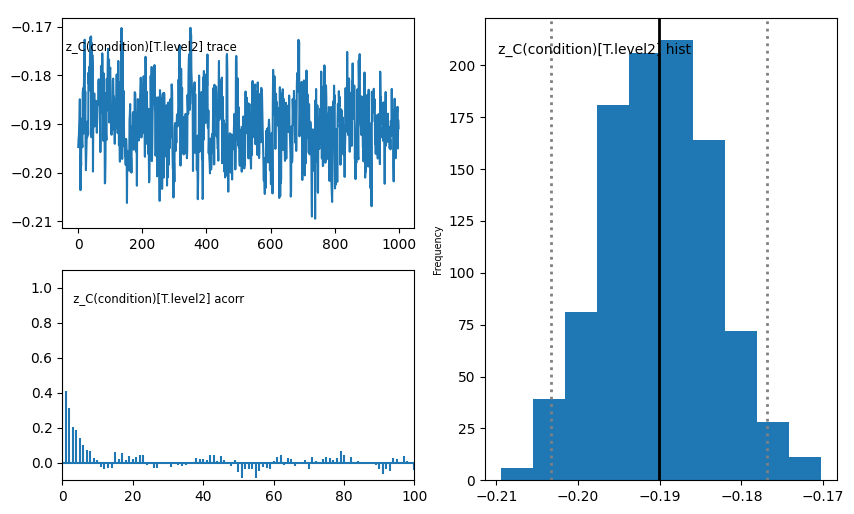

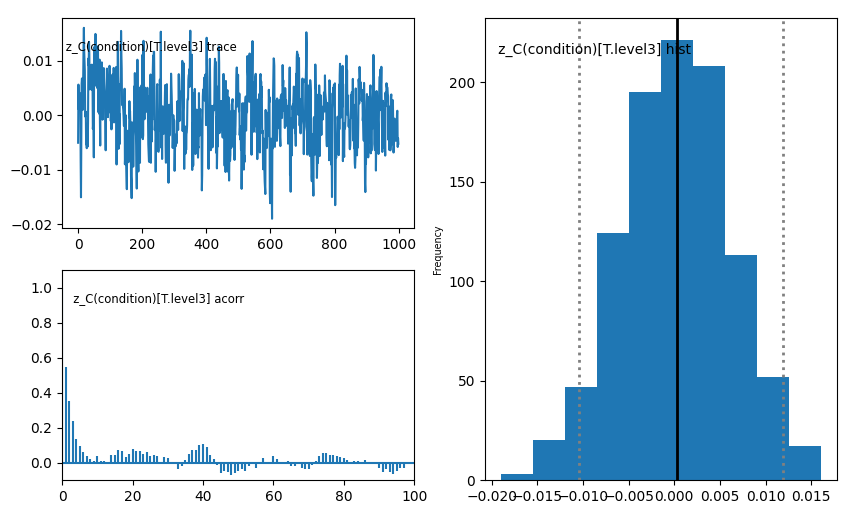

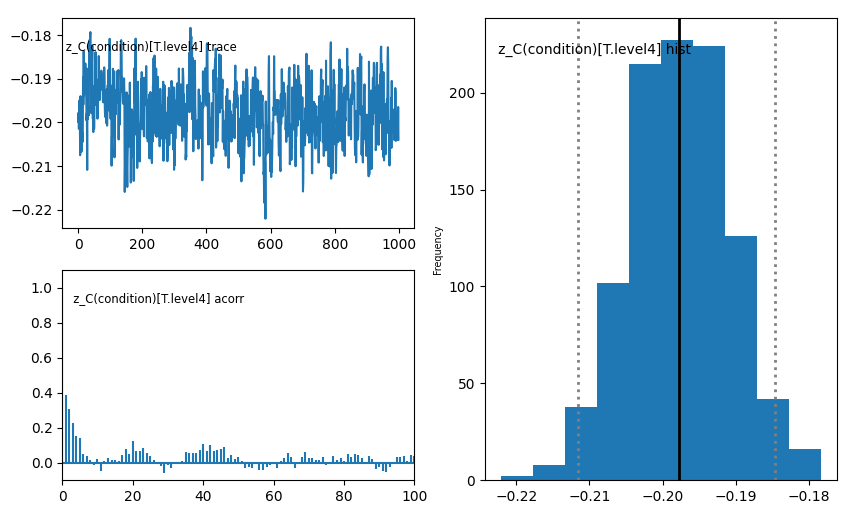

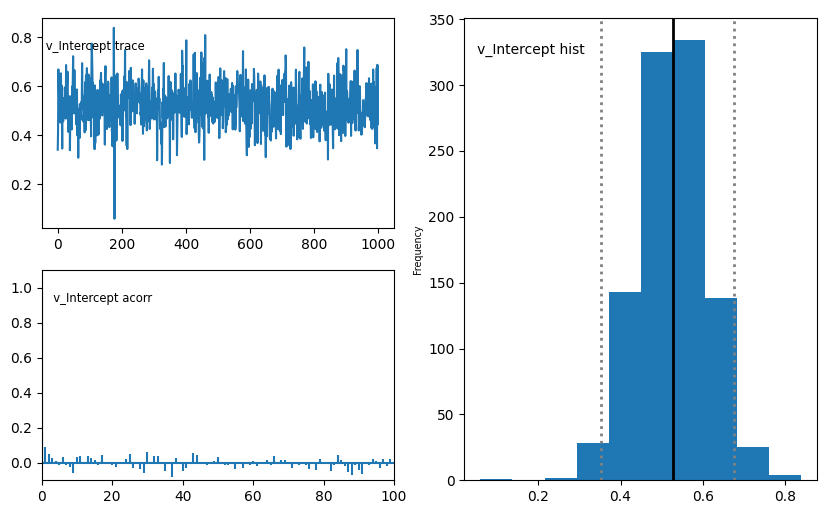

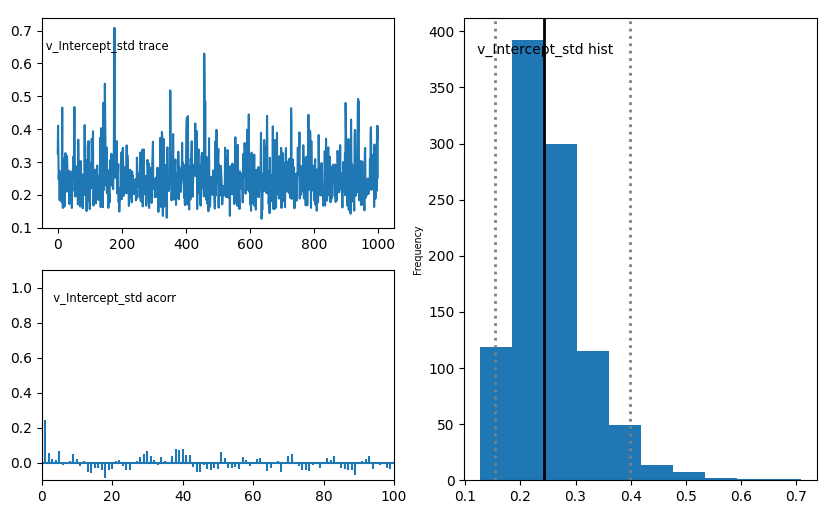

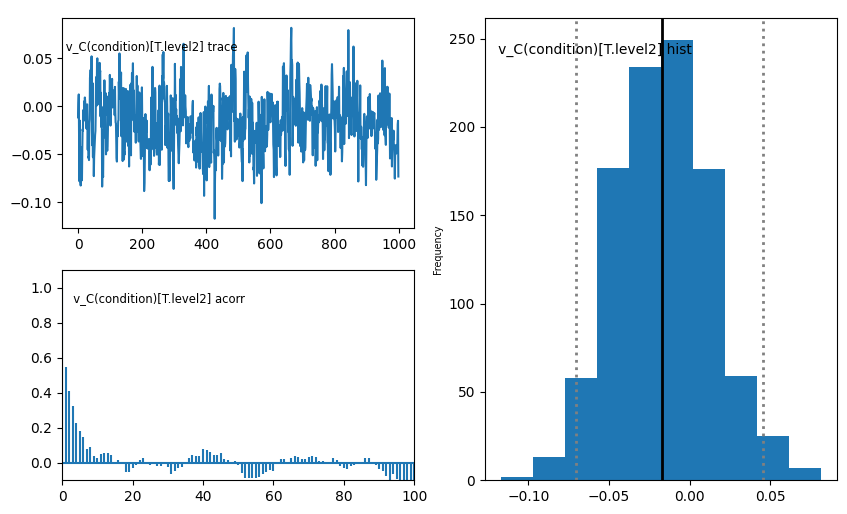

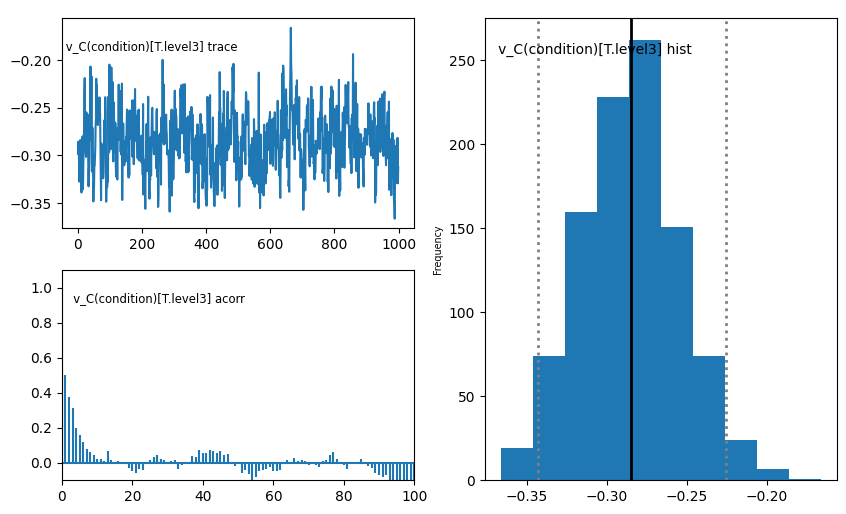

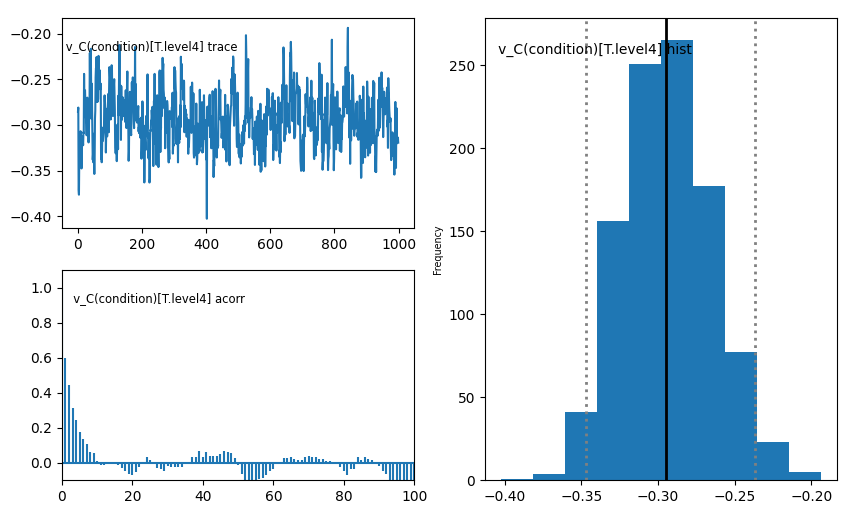

In [20]:
m_reg4.plot_posteriors()

In [21]:
m_reg4.dic

32403.08204329438